# Technical Analysis Indicator Price Prediction
The goal of this project is to analyze the predictive power of the top 10 most popular TA indicators and see how well they do to predict price over a 30 day period. I am going to find the value of the indicators on day 1 (30 trading days ago) and then find the daily closing price for 30 days later and measure how well the indicator predicted the price.  

first we'll find the top 500 stocks by market cap from nasdaq and pull them into a dataframe


In [1]:
# Importing pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv' 
df = pd.read_csv(csv_file_path)

# Inspect the DataFrame to understand its structure
print(df.head())

# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df = df[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df['Market Cap'] = df['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_sorted = df.sort_values(by='Market Cap', ascending=False).head(5000)                                                                        
df_sorted.head()


  Symbol                                               Name Last Sale  \
0      A             Agilent Technologies Inc. Common Stock   $138.31   
1     AA                    Alcoa Corporation Common Stock     $34.50   
2   AACG   ATA Creativity Global American Depositary Shares   $0.5025   
3   AACT  Ares Acquisition Corporation II Class A Ordina...    $10.80   
4   AADI                  Aadi Bioscience Inc. Common Stock     $1.88   

   Net Change % Change    Market Cap        Country  IPO Year    Volume  \
0      1.0000   0.728%  3.974029e+10  United States    1999.0    887040   
1      1.9800   6.089%  8.912735e+09  United States    2016.0  10730428   
2     -0.0275  -5.189%  1.608006e+07          China    2008.0     25043   
3      0.0200   0.186%  0.000000e+00            NaN    2023.0     35074   
4      0.0800   4.444%  4.627589e+07  United States       NaN     81942   

        Sector                                          Industry  
0  Industrials  Biotechnology: Laboratory A

,Symbol,Name,Market Cap
15,AAPL,Apple Inc. Common Stock,3.288959e+12
4208,MSFT,Microsoft Corporation Common Stock,3.206167e+12
4559,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
2819,GOOG,Alphabet Inc. Class C Capital Stock,1.957167e+12
2820,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12


In [2]:
# Reset the index of the DataFrame and drop the old index
df_sorted.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_sorted.index = df_sorted.index + 1

# Display the first few rows of the updated DataFrame
df_sorted.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOG,Alphabet Inc. Class C Capital Stock,1.957167e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12


remove all stocks except common stocks

In [3]:
# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", 
                 "Registry Shares", "Depositary Shares"
]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, 
# there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_filtered = df_sorted[~df_sorted['Name'].str.contains(pattern, case=False, 
                                                        na=False)
]

# Display the filtered DataFrame
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
6,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


In [7]:
# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_filtered.index = df_filtered.index + 1

# Display the first few rows of the updated DataFrame
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
5,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


below are the 10 technical indicators we are going to use for this project.
1. Relative Strength Index (RSI)
2. Moving Average Convergence Divergence (MACD)
3. Stochastic Oscillator
4. Simple Moving Average (SMA)
5. Exponential Moving Average (EMA)
6. Volume Weighted Average Price (VWAP)
7. Bollinger Bands
8. Average True Range (ATR)
9. Fibonacci Retracement 

In [ ]:
# There is a CSV file I have provided so this code does not need to be run again
# Computationally intensive

import yfinance as yf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Function to download stock data for a single stock
def download_stock_data(ticker):
    try:
        data = yf.download(ticker, start="2022-02-10", end="2025-02-10", interval="1d")[['Close', 'High', 'Low', 'Volume']]
        if data.empty:
            print(f"Warning: No data found for {ticker} (possibly due to non-trading days like weekends or holidays)")
            return None  # Return None if the data is empty
        return data
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return None  # Return None if there is any error (e.g., stock not found)

# List of tickers from your df_filtered dataframe
tickers = df_filtered['Symbol'].tolist()

# Batch size for processing tickers in chunks
batch_size = 100

# Create a function to download data for a batch of tickers in parallel
def download_batch(batch_tickers):
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(download_stock_data, batch_tickers))
    # Remove None values from the results
    return [result for result in results if result is not None]

# Loop through the tickers in batches
for i in range(0, len(tickers), batch_size):
    batch_tickers = tickers[i:i + batch_size]
    results = download_batch(batch_tickers)

    if results:  # Check if results are not empty
        # Combine all individual stock data into a single dataframe
        df_batch = pd.concat(results, keys=batch_tickers)

        # Save the data to CSV for the current batch
        df_batch.to_csv(f'/content/drive/MyDrive/stock_data_yahoo_{i // batch_size}.csv')
        print(f"Downloaded batch {i // batch_size} and saved to CSV")
    else:
        print(f"Batch {i // batch_size} has no data. Skipping...")
        # Optionally, log the tickers that failed for this batch
        print(f"Failed tickers in batch {i // batch_size}: {batch_tickers}")


In [10]:
import pandas as pd

# Initialize an empty list to hold DataFrames
df_list = []

# List of specific file indices
file_indices = [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, 45, 44, 26, 18, 46]

# Loop through the specific CSV file indices
for i in file_indices:
    # Construct the file path for each batch
    csv_file_path = f'/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_data_yahoo_{i}.csv'

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Rename 'Price' column to 'Symbol'
    df = df.rename(columns={'Price': 'Symbol'})

    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames in the list along the rows (axis=0)
df_all = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the merged DataFrame
df_all.head()


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/562544689.py:15: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/562544689.py:15: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/5625446

,Symbol,Unnamed: 1,Close,Close.1,High,High.1,Low,Low.1,Volume,Volume.1,...,Low.21,Volume.21,Close.22,High.22,Low.22,Volume.22,Close.23,High.23,Low.23,Volume.23
0,Ticker,NaN,CCCS,POST,CCCS,POST,CCCS,POST,CCCS,POST,...,WTS,WTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,69.12957763671875,10.729999542236328,70.2225112915039,10.199999809265137,68.92015838623047,1037700.0,642524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2022-02-11,10.09000015258789,69.76439666748047,10.489999771118164,70.5235595703125,10.020000457763672,68.95942687988281,480300.0,492169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-02-14,10.220000267028809,71.02094268798828,10.460000038146973,71.27617645263672,9.970000267028809,69.64659881591797,724400.0,672473.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Get a list of distinct tickers in the 'Symbol' column
distinct_symbols = df_all['Symbol'].unique()

# Count the number of distinct symbols
num_distinct_symbols = len(distinct_symbols)

# Print the result
print(f"Number of distinct symbols: {num_distinct_symbols}")

# Optionally, print the list of distinct symbols (first 10 for brevity)
print(f"List of distinct symbols (first 10): {distinct_symbols[:10]}")


Number of distinct symbols: 1792
List of distinct symbols (first 10): ['Ticker' nan 'AAPL' 'MSFT' 'NVDA' 'GOOGL' 'AMZN' 'META' 'BRK/A' 'BRK/B']


In [12]:
# Get the list of unique symbols from df_all and df_filtered
unique_symbols_all = df_all['Symbol'].unique()
unique_symbols_filtered = df_filtered['Symbol'].unique()

# Find the symbols that are in df_all but not in df_filtered, ensuring all items are strings
symbols_not_in_filtered = [str(symbol) for symbol in unique_symbols_all if str(symbol) not in map(str, unique_symbols_filtered)]

# Print the list of symbols that are not in df_filtered
print('\n'.join(symbols_not_in_filtered))


Ticker
nan


In [13]:
import numpy as np

# Convert 'nan' strings or any NaN-like values to actual np.nan
df_all['Symbol'] = df_all['Symbol'].apply(lambda x: np.nan if (isinstance(x, str) and x.lower() == 'nan') or pd.isna(x) else x)

# Drop rows where the 'Symbol' column contains NaN values
df_all_cleaned = df_all.dropna(subset=['Symbol'])

# Verify the result by checking the first few rows
df_all_cleaned.head()


,Symbol,Unnamed: 1,Close,Close.1,High,High.1,Low,Low.1,Volume,Volume.1,...,Low.21,Volume.21,Close.22,High.22,Low.22,Volume.22,Close.23,High.23,Low.23,Volume.23
0,Ticker,NaN,CCCS,POST,CCCS,POST,CCCS,POST,CCCS,POST,...,WTS,WTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,69.12957763671875,10.729999542236328,70.2225112915039,10.199999809265137,68.92015838623047,1037700.0,642524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2022-02-11,10.09000015258789,69.76439666748047,10.489999771118164,70.5235595703125,10.020000457763672,68.95942687988281,480300.0,492169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-02-14,10.220000267028809,71.02094268798828,10.460000038146973,71.27617645263672,9.970000267028809,69.64659881591797,724400.0,672473.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,AAPL,2022-02-15,10.5600004196167,71.5575942993164,10.569999694824219,72.25785064697266,10.220000267028809,70.99476623535156,758700.0,380319.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# This will ensure that if any main column (Close, High, Low, or Volume)
# has missing values, they will be filled with the corresponding values
# from the suffixed columns (e.g., Close.1, Close.2, etc.), and once done,
# the suffixed columns will be removed from the DataFrame.

import re

# List of main columns
main_columns = ['Close', 'High', 'Low', 'Volume']

# Iterate over the main columns to check and replace NaN values with corresponding suffixed columns
for col in main_columns:
    # Look for columns with numeric suffixes like .1, .2, .3, ..., .23
    suffix_columns = [col + '.' + str(i) for i in range(1, 24)]  # Create the list of possible suffixes

    # For each suffix column, if it exists, fill NaN in the main column with its values
    for suffix_col in suffix_columns:
        if suffix_col in df_all.columns:
            df_all[col] = df_all[col].fillna(df_all[suffix_col])

    # After filling NaN values from the suffixed columns, drop the suffixed columns
    df_all_cleaned = df_all.drop(columns=suffix_columns)

# Verify the changes
print(df_all_cleaned.head())


   Symbol  Unnamed: 1               Close            Close.1  \
0  Ticker         NaN                CCCS               POST   
1     NaN        Date                 NaN                NaN   
2    AAPL  2022-02-10  10.520000457763672  69.12957763671875   
3    AAPL  2022-02-11   10.09000015258789  69.76439666748047   
4    AAPL  2022-02-14  10.220000267028809  71.02094268798828   

                 High             High.1                 Low  \
0                CCCS               POST                CCCS   
1                 NaN                NaN                 NaN   
2  10.729999542236328   70.2225112915039  10.199999809265137   
3  10.489999771118164   70.5235595703125  10.020000457763672   
4  10.460000038146973  71.27617645263672   9.970000267028809   

               Low.1     Volume Close.2  ... Low.20 Close.21 High.21 Low.21  \
0               POST       CCCS    LOAR  ...    KBH      WTS     WTS    WTS   
1                NaN        NaN     NaN  ...    NaN      NaN     NaN    

In [15]:
df_all_cleaned.columns

Index(['Symbol', 'Unnamed: 1', 'Close', 'Close.1', 'High', 'High.1', 'Low',
       'Low.1', 'Volume', 'Close.2', 'High.2', 'Low.2', 'Close.3', 'High.3',
       'Low.3', 'Close.4', 'High.4', 'Low.4', 'Close.5', 'High.5', 'Low.5',
       'Close.6', 'High.6', 'Low.6', 'Close.7', 'High.7', 'Low.7', 'Close.8',
       'High.8', 'Low.8', 'Close.9', 'High.9', 'Low.9', 'Close.10', 'High.10',
       'Low.10', 'Close.11', 'High.11', 'Low.11', 'Close.12', 'High.12',
       'Low.12', 'Close.13', 'High.13', 'Low.13', 'Close.14', 'High.14',
       'Low.14', 'Close.15', 'High.15', 'Low.15', 'Close.16', 'High.16',
       'Low.16', 'Close.17', 'High.17', 'Low.17', 'Close.18', 'High.18',
       'Low.18', 'Close.19', 'High.19', 'Low.19', 'Close.20', 'High.20',
       'Low.20', 'Close.21', 'High.21', 'Low.21', 'Close.22', 'High.22',
       'Low.22', 'Close.23', 'High.23', 'Low.23'],
      dtype='object')

In [16]:
# List of columns you want to keep
columns_to_keep = ['Symbol', 'Unnamed: 1', 'Close', 'High', 'Low', 'Volume']

# Select only the columns you want to keep and drop the others
df_all_cleaned = df_all_cleaned[columns_to_keep]

# Verify the result by checking the first few rows
df_all_cleaned.head()


,Symbol,Unnamed: 1,Close,High,Low,Volume
0,Ticker,NaN,CCCS,CCCS,CCCS,CCCS
1,NaN,Date,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0
3,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0
4,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0


In [17]:
# Rename the 'Unnamed: 1' column to 'Date'
df_all_cleaned = df_all_cleaned.rename(columns={'Unnamed: 1': 'Date'})

# Verify the change by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume
0,Ticker,NaN,CCCS,CCCS,CCCS,CCCS
1,NaN,Date,NaN,NaN,NaN,NaN
2,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0
3,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0
4,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0


In [18]:
# Drop rows with index 0 and 1
df_all_cleaned = df_all_cleaned.drop([0, 1])

# Reset the index
df_all_cleaned = df_all_cleaned.reset_index(drop=True)

# Verify the changes by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume
0,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0
1,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0
2,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0
3,AAPL,2022-02-15,10.5600004196167,10.569999694824219,10.220000267028809,758700.0
4,AAPL,2022-02-16,10.4399995803833,10.550000190734863,10.390000343322754,685200.0


In [20]:
# Check for non-numeric values in the 'Close' column
non_numeric_values = df_all_cleaned[~df_all_cleaned['Close'].apply(pd.to_numeric, errors='coerce').notna()]
print(non_numeric_values[['Date', 'Symbol', 'Close']].head())

        Date  Symbol Close
57472    NaN  Ticker  MASI
57473   Date     NaN   NaN
109293   NaN  Ticker  BILL
109294  Date     NaN   NaN
169643   NaN  Ticker   NVO


In [21]:
df_all_cleaned = df_all_cleaned[pd.to_numeric(df_all_cleaned['Close'], errors='coerce').notna()]


In [22]:
# Simple Moving Average
# 5 Day SMA, 20 Day SMA, and 50 Day SMA

# Group by 'Symbol' and then apply rolling averages within each group
df_all_cleaned['SMA_5'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
df_all_cleaned['SMA_20'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=20, min_periods=1).mean().reset_index(level=0, drop=True)
df_all_cleaned['SMA_50'] = df_all_cleaned.groupby('Symbol')['Close'].rolling(window=50, min_periods=1).mean().reset_index(level=0, drop=True)

# Verify the results by checking the first few rows
df_all_cleaned.head(10)



,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50
0,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000
1,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000
2,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667
3,AAPL,2022-02-15,10.5600004196167,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500
4,AAPL,2022-02-16,10.4399995803833,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000
5,AAPL,2022-02-17,10.1899995803833,10.399999618530273,10.109999656677246,609500.0,10.300000,10.336667,10.336667
6,AAPL,2022-02-18,10.09000015258789,10.3100004196167,10.069999694824219,623100.0,10.300000,10.301429,10.301429
7,AAPL,2022-02-22,10.149999618530273,10.279999732971191,9.920000076293945,733000.0,10.286000,10.282500,10.282500
8,AAPL,2022-02-23,9.930000305175781,10.329999923706055,9.930000305175781,625600.0,10.160000,10.243333,10.243333
9,AAPL,2022-02-24,10.460000038146973,10.479999542236328,9.680000305175781,1043800.0,10.164000,10.265000,10.265000


In [23]:
# Exponential Moving Average

# Exponential Moving Average (EMA)
# 5 Day EMA, 20 Day EMA, and 50 Day EMA

# Group by 'Symbol' and then apply ewm (Exponential Moving Average) within each group
df_all_cleaned['EMA_5'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=5, adjust=False).mean().reset_index(level=0, drop=True)
df_all_cleaned['EMA_20'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=20, adjust=False).mean().reset_index(level=0, drop=True)
df_all_cleaned['EMA_50'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=50, adjust=False).mean().reset_index(level=0, drop=True)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50
0,AAPL,2022-02-10,10.520000457763672,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000
1,AAPL,2022-02-11,10.09000015258789,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138
2,AAPL,2022-02-14,10.220000267028809,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034
3,AAPL,2022-02-15,10.5600004196167,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700
4,AAPL,2022-02-16,10.4399995803833,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555


In [25]:
df_all_cleaned['Close'] = pd.to_numeric(df_all_cleaned['Close'], errors='coerce')


In [26]:
# RSI


# Define a function to calculate RSI
def calculate_rsi(df, window=14):
    # Calculate price changes
    delta = df['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Apply the function to the dataframe to calculate RSI
df_all_cleaned['RSI'] = calculate_rsi(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50,RSI
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,NaN
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138,NaN
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034,NaN
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700,NaN
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555,NaN


In [27]:
# MACD

# Calculate the 12-day EMA (Fast EMA) and reset the index
df_all_cleaned['EMA_12_MACD'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=12, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the 26-day EMA (Slow EMA) and reset the index
df_all_cleaned['EMA_26_MACD'] = df_all_cleaned.groupby('Symbol')['Close'].ewm(span=26, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the MACD (12-day EMA - 26-day EMA)
df_all_cleaned['MACD'] = df_all_cleaned['EMA_12_MACD'] - df_all_cleaned['EMA_26_MACD']

# Calculate the Signal Line (9-day EMA of the MACD) and reset the index
df_all_cleaned['Signal_Line'] = df_all_cleaned.groupby('Symbol')['MACD'].ewm(span=9, adjust=False).mean().reset_index(level=0, drop=True)

# Calculate the MACD Histogram (MACD - Signal Line)
df_all_cleaned['MACD_Histogram'] = df_all_cleaned['MACD'] - df_all_cleaned['Signal_Line']

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50,RSI,EMA_12_MACD,EMA_26_MACD,MACD,Signal_Line,MACD_Histogram
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,NaN,10.520000,10.520000,0.000000,0.000000,0.000000
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138,NaN,10.453847,10.488149,-0.034302,-0.006860,-0.027442
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034,NaN,10.417870,10.468286,-0.050416,-0.015571,-0.034844
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700,NaN,10.439736,10.475079,-0.035343,-0.019526,-0.015817
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555,NaN,10.439777,10.472481,-0.032704,-0.022161,-0.010543


In [28]:
# stochastic oscillator
# Calculate the Stochastic Oscillator (%K)
df_all_cleaned['Stoch_Lowest_Low_14'] = df_all_cleaned.groupby('Symbol')['Low'].rolling(window=14).min().reset_index(level=0, drop=True)
df_all_cleaned['Stoch_Highest_High_14'] = df_all_cleaned.groupby('Symbol')['High'].rolling(window=14).max().reset_index(level=0, drop=True)

df_all_cleaned['%K'] = ((df_all_cleaned['Close'] - df_all_cleaned['Stoch_Lowest_Low_14']) / (df_all_cleaned['Stoch_Highest_High_14'] - df_all_cleaned['Stoch_Lowest_Low_14'])) * 100

# Calculate the %D (3-day Simple Moving Average of %K)
df_all_cleaned['%D'] = df_all_cleaned.groupby('Symbol')['%K'].rolling(window=3).mean().reset_index(level=0, drop=True)

# Drop intermediate columns if you don't need them
df_all_cleaned.drop(columns=['Stoch_Lowest_Low_14', 'Stoch_Highest_High_14'], inplace=True)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,EMA_20,EMA_50,RSI,EMA_12_MACD,EMA_26_MACD,MACD,Signal_Line,MACD_Histogram,%K,%D
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,10.520000,10.520000,NaN,10.520000,10.520000,0.000000,0.000000,0.000000,NaN,NaN
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,10.479048,10.503138,NaN,10.453847,10.488149,-0.034302,-0.006860,-0.027442,NaN,NaN
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,10.454377,10.492034,NaN,10.417870,10.468286,-0.050416,-0.015571,-0.034844,NaN,NaN
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,10.464436,10.494700,NaN,10.439736,10.475079,-0.035343,-0.019526,-0.015817,NaN,NaN
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,10.462109,10.492555,NaN,10.439777,10.472481,-0.032704,-0.022161,-0.010543,NaN,NaN


In [29]:
# VWAP

# Calculate Volume Weighted Average Price (VWAP) per symbol
def calculate_vwap(df):
    # Ensure 'Close' and 'Volume' are numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Group by 'Symbol' and calculate VWAP for each symbol
    df['Cumulative_Price_Volume'] = df.groupby('Symbol').apply(
        lambda x: (x['Close'] * x['Volume']).cumsum()).reset_index(level=0, drop=True)

    df['Cumulative_Volume'] = df.groupby('Symbol').apply(
        lambda x: x['Volume'].cumsum()).reset_index(level=0, drop=True)

    # Calculate VWAP as the ratio of cumulative sums for each group (symbol)
    df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

    return df

# Apply the function to calculate VWAP
df_all_cleaned = calculate_vwap(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,EMA_12_MACD,EMA_26_MACD,MACD,Signal_Line,MACD_Histogram,%K,%D,Cumulative_Price_Volume,Cumulative_Volume,VWAP
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.520000,10.520000,0.000000,0.000000,0.000000,NaN,NaN,1.091660e+07,1037700.0,10.520000
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.453847,10.488149,-0.034302,-0.006860,-0.027442,NaN,NaN,1.576283e+07,1518000.0,10.383947
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.417870,10.468286,-0.050416,-0.015571,-0.034844,NaN,NaN,2.316620e+07,2242400.0,10.330985
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.439736,10.475079,-0.035343,-0.019526,-0.015817,NaN,NaN,3.117807e+07,3001100.0,10.388881
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.439777,10.472481,-0.032704,-0.022161,-0.010543,NaN,NaN,3.833156e+07,3686300.0,10.398383


In [30]:
# Calculate Bollinger Bands per symbol
def calculate_bollinger_bands(df, window=20):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Calculate the rolling mean (Middle Band) and rolling standard deviation
    df['Middle_Band'] = df.groupby('Symbol')['Close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Std_Dev'] = df.groupby('Symbol')['Close'].rolling(window=window, min_periods=1).std().reset_index(level=0, drop=True)

    # Calculate the Upper and Lower Bands
    df['Upper_Band'] = df['Middle_Band'] + (df['Std_Dev'] * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Std_Dev'] * 2)

    return df

# Apply the function to calculate Bollinger Bands
df_all_cleaned = calculate_bollinger_bands(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,MACD_Histogram,%K,%D,Cumulative_Price_Volume,Cumulative_Volume,VWAP,Middle_Band,Std_Dev,Upper_Band,Lower_Band
0,AAPL,2022-02-10,10.52,10.729999542236328,10.199999809265137,1037700.0,10.520000,10.520000,10.520000,10.520000,...,0.000000,NaN,NaN,1.091660e+07,1037700.0,10.520000,10.520000,NaN,NaN,NaN
1,AAPL,2022-02-11,10.09,10.489999771118164,10.020000457763672,480300.0,10.305000,10.305000,10.305000,10.376667,...,-0.027442,NaN,NaN,1.576283e+07,1518000.0,10.383947,10.305000,0.304056,10.913113,9.696888
2,AAPL,2022-02-14,10.22,10.460000038146973,9.970000267028809,724400.0,10.276667,10.276667,10.276667,10.324445,...,-0.034844,NaN,NaN,2.316620e+07,2242400.0,10.330985,10.276667,0.220530,10.717727,9.835607
3,AAPL,2022-02-15,10.56,10.569999694824219,10.220000267028809,758700.0,10.347500,10.347500,10.347500,10.402963,...,-0.015817,NaN,NaN,3.117807e+07,3001100.0,10.388881,10.347500,0.229111,10.805722,9.889279
4,AAPL,2022-02-16,10.44,10.550000190734863,10.390000343322754,685200.0,10.366000,10.366000,10.366000,10.415309,...,-0.010543,NaN,NaN,3.833156e+07,3686300.0,10.398383,10.366000,0.202682,10.771364,9.960636


In [31]:
# Average True Range (ATR)

# Function to calculate True Range (TR)
def calculate_true_range(df):
    # Convert relevant columns to numeric (if not already numeric)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Ensure previous close is calculated per stock symbol to prevent cross-stock contamination
    df['ATR_Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ATR_High_Low'] = df['High'] - df['Low']  # High - Low
    df['ATR_High_Close'] = (df['High'] - df['ATR_Prev_Close']).abs()  # High - Prev Close
    df['ATR_Low_Close'] = (df['Low'] - df['ATR_Prev_Close']).abs()  # Low - Prev Close

    # True Range is the max of the three
    df['ATR_True_Range'] = df[['ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close']].max(axis=1)

    return df

# Function to calculate Average True Range (ATR)
def calculate_atr(df, window=14):
    # Apply the True Range calculation
    df = calculate_true_range(df)

    # Compute ATR within each stock symbol
    df['ATR'] = df.groupby('Symbol')['ATR_True_Range'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    return df

# Apply the function to calculate ATR
df_all_cleaned = calculate_atr(df_all_cleaned)

# Verify the results by checking the first few rows
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,Middle_Band,Std_Dev,Upper_Band,Lower_Band,ATR_Prev_Close,ATR_High_Low,ATR_High_Close,ATR_Low_Close,ATR_True_Range,ATR
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.520000,NaN,NaN,NaN,NaN,0.530000,NaN,NaN,0.530000,0.530000
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.305000,0.304056,10.913113,9.696888,10.52,0.469999,0.030001,0.50,0.500000,0.515000
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.276667,0.220530,10.717727,9.835607,10.09,0.490000,0.370000,0.12,0.490000,0.506667
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.347500,0.229111,10.805722,9.889279,10.22,0.349999,0.349999,0.00,0.349999,0.467500
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.366000,0.202682,10.771364,9.960636,10.56,0.160000,0.010000,0.17,0.170000,0.408000


In [32]:
# Fibonacci Retracement levels

import numpy as np
import pandas as pd

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_30_day(df, window=30):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_30_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_30_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'30_day_Fib_{int(level*100)}'] = stock_df['Fib_30_High_Max'] - (level * (stock_df['Fib_30_High_Max'] - stock_df['Fib_30_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df

# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_10_day(df, window=10):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_10_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_10_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'10_day_Fib_{int(level*100)}'] = stock_df['Fib_10_High_Max'] - (level * (stock_df['Fib_10_High_Max'] - stock_df['Fib_10_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df


# Function to calculate Fibonacci Retracement levels
def calculate_fibonacci_retracement_5_day(df, window=5):
    # Convert relevant columns to numeric
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

    # Define Fibonacci levels
    fib_levels = [0.236, 0.382, 0.500, 0.618, 1.000]

    # Group by 'Symbol' and calculate Fibonacci levels for a given window
    def fib_retracement(stock_df):
        stock_df['Fib_5_High_Max'] = stock_df['High'].rolling(window=window, min_periods=1).max()
        stock_df['Fib_5_Low_Min'] = stock_df['Low'].rolling(window=window, min_periods=1).min()

        # Calculate Fibonacci retracement levels
        for level in fib_levels:
            stock_df[f'5_day-Fib_{int(level*100)}'] = stock_df['Fib_5_High_Max'] - (level * (stock_df['Fib_5_High_Max'] - stock_df['Fib_5_Low_Min']))

        return stock_df

    # Apply the function to each stock symbol
    df = df.groupby('Symbol', group_keys=False).apply(fib_retracement)

    return df

# Apply Fibonacci Retracement calculation to the dataframe
df_all_cleaned = calculate_fibonacci_retracement_30_day(df_all_cleaned, window=30)
df_all_cleaned = calculate_fibonacci_retracement_10_day(df_all_cleaned, window=10)
df_all_cleaned = calculate_fibonacci_retracement_5_day(df_all_cleaned, window=5)

# Display the first few rows to verify results
df_all_cleaned.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,10_day_Fib_50,10_day_Fib_61,10_day_Fib_100,Fib_5_High_Max,Fib_5_Low_Min,5_day-Fib_23,5_day-Fib_38,5_day-Fib_50,5_day-Fib_61,5_day-Fib_100
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.465,10.40246,10.20,10.73,10.20,10.60492,10.52754,10.465,10.40246,10.20
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.375,10.29122,10.02,10.73,10.02,10.56244,10.45878,10.375,10.29122,10.02
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97


In [33]:
# Save DataFrame as CSV file for easy access
df_all_cleaned.to_csv('/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_ta_data.csv', index=False)

In [34]:
# Specify the file path to your CSV in Google Drive
csv_file_path = '/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_ta_data.csv'

# Load the CSV file into a DataFrame
df_all_cleaned = pd.read_csv(csv_file_path)

# Inspect the DataFrame
df_all_cleaned.head()

,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,10_day_Fib_50,10_day_Fib_61,10_day_Fib_100,Fib_5_High_Max,Fib_5_Low_Min,5_day-Fib_23,5_day-Fib_38,5_day-Fib_50,5_day-Fib_61,5_day-Fib_100
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.465,10.40246,10.20,10.73,10.20,10.60492,10.52754,10.465,10.40246,10.20
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.375,10.29122,10.02,10.73,10.02,10.56244,10.45878,10.375,10.29122,10.02
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97


In [35]:
df_stocks_price_ta =df_all_cleaned.copy()
df_stocks_price_ta.head()

,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,10_day_Fib_50,10_day_Fib_61,10_day_Fib_100,Fib_5_High_Max,Fib_5_Low_Min,5_day-Fib_23,5_day-Fib_38,5_day-Fib_50,5_day-Fib_61,5_day-Fib_100
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,10.465,10.40246,10.20,10.73,10.20,10.60492,10.52754,10.465,10.40246,10.20
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,10.375,10.29122,10.02,10.73,10.02,10.56244,10.45878,10.375,10.29122,10.02
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,10.350,10.26032,9.97,10.73,9.97,10.55064,10.43968,10.350,10.26032,9.97


In [36]:
# Create a new dataframe called 'df_stock_data_1_week' as a copy of 'df_stocks_price_ta'
df_stock_data_1_week = df_stocks_price_ta.copy()

# List of columns to create lags for (focusing on short-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_1_week[f'{col}_lag_{lag}'] = df_stock_data_1_week[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_1_week.head()


,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,SMA_5_lag_5,SMA_5_lag_7,EMA_5_lag_1,EMA_5_lag_3,EMA_5_lag_5,EMA_5_lag_7,Volume_lag_1,Volume_lag_3,Volume_lag_5,Volume_lag_7
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,NaN,NaN,10.520000,NaN,NaN,NaN,1037700.0,NaN,NaN,NaN
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,NaN,NaN,10.376667,NaN,NaN,NaN,480300.0,NaN,NaN,NaN
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,NaN,NaN,10.324445,10.520000,NaN,NaN,724400.0,1037700.0,NaN,NaN
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,NaN,NaN,10.402963,10.376667,NaN,NaN,758700.0,480300.0,NaN,NaN


In [37]:
print(df_stock_data_1_week['Date'].dtype)


object


In [38]:
df_stock_data_1_week['Date'] = pd.to_datetime(df_stock_data_1_week['Date'], errors='coerce')
print(df_stock_data_1_week['Date'].dtype)

datetime64[ns]


In [224]:
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# baseline model

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_baseline = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_baseline = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_baseline['Close_Target'] = df_stock_data_train_1_week_baseline.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_baseline['Close_Target'] = df_stock_data_test_1_week_baseline.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_baseline = df_stock_data_train_1_week_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_baseline = df_stock_data_test_1_week_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_baseline[numeric_cols_train] = df_stock_data_train_1_week_baseline[numeric_cols_train].fillna(df_stock_data_train_1_week_baseline[numeric_cols_train].median())
df_stock_data_test_1_week_baseline[numeric_cols_test] = df_stock_data_test_1_week_baseline[numeric_cols_test].fillna(df_stock_data_test_1_week_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_week_baseline = df_stock_data_train_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_baseline = df_stock_data_train_1_week_baseline['Close_Target']

# Create X and y for testing
X_test_1_week_baseline = df_stock_data_test_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_baseline = df_stock_data_test_1_week_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_baseline shape: {X_train_1_week_baseline.shape}, y_train_1_week_baseline shape: {y_train_1_week_baseline.shape}")
print(f"X_test_1_week_baseline shape: {X_test_1_week_baseline.shape}, y_test_1_week_baseline shape: {y_test_1_week_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_baseline.shape[0] == 0 or X_test_1_week_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week.fit(X_train_1_week_baseline, y_train_1_week_baseline)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_baseline = model_baseline_1_week.predict(X_test_1_week_baseline)

# Calculate performance on the test data
mse_test_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_baseline}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3414160196.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_baseline['Close_Target'] = df_stock_data_train_1_week_baseline.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3414160196.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_baseline['Close_Target'] = df_stock_data_test_1_week_baseline.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_baseline shape: (867895, 67), y_train_1_week_baseline shape: (867895,)
X_test_1_week_baseline shape: (430180, 67), y_test_1_week_baseline shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9222.592316604241


In [226]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_baseline` are your predictions for the test data and `y_test_1_week_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
mae_1_week_baseline = mean_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
rmse_1_week_baseline = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_baseline = r2_score(y_test_1_week_baseline, y_pred_1_week_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_baseline}')
print(f'R-squared on unseen data: {r2_1_week_baseline}')

# Additional metrics
medae_1_week_baseline = median_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_week_baseline}')

dw_stat_1_week_baseline = durbin_watson(y_test_1_week_baseline - y_pred_1_week_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_baseline = np.mean(np.abs((y_test_1_week_baseline - y_pred_1_week_baseline) / y_test_1_week_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_week_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_baseline = dict(zip(X_train_1_week_baseline.columns, model_baseline_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_baseline = sorted(feature_importance_1_week_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9222.592316604241
Mean Absolute Error on unseen data: 11.174428157067275
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.9582968719645971
Median Absolute Error on unseen data: 1.6202430725097656
Durbin-Watson Statistic on unseen data: 0.12107588672303043
MAPE on unseen data: 4.06%
Fib_10_Low_Min: 57.64%
Fib_30_High_Max: 16.90%
Low: 5.14%
High: 4.55%
5_day-Fib_61: 3.14%
Fib_30_Low_Min: 2.50%
5_day-Fib_38: 1.71%
EMA_5: 1.67%
5_day-Fib_50: 1.28%
Volume: 1.20%
30_day_Fib_50: 0.78%
SMA_5: 0.73%
SMA_50: 0.49%
EMA_50: 0.31%
30_day_Fib_61: 0.28%
Fib_5_Low_Min: 0.26%
Cumulative_Price_Volume: 0.21%
VWAP: 0.20%
ATR_Prev_Close: 0.16%
Std_Dev: 0.15%
5_day-Fib_23: 0.10%
10_day_Fib_23: 0.08%
Fib_5_High_Max: 0.07%
30_day_Fib_38: 0.06%
ATR_True_Range: 0.06%
Lower_Band: 0.06%
EMA_26_MACD: 0.04%
Cumulative_Volume: 0.04%
ATR: 0.02%
Fib_10_High_Max: 0.02%
SMA_20: 0.02%
30_day_Fib_23: 0.02%
Upper_Band: 0.02%
ATR_High_Low: 0.01%
Volume

In [41]:
# we're going to use the scaled data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%
# first we need to get a list of important feautres from our baseline
# model and create a new dataframe containing only those features
# Get feature importance as a dictionary
# Get feature importance as a dictionary
feature_importance = dict(zip(X_train.columns, model_baseline_1_week.feature_importances_))

# Filter features with importance greater than 1%
important_features = {feature: importance for feature, importance in feature_importance.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Extract the features names (keys) into a list
important_feature_names = [feature for feature, importance in sorted_important_features]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names)



Features with more than 1% contribution:
Fib_10_Low_Min: 57.64%
Fib_30_High_Max: 16.90%
Low: 5.14%
High: 4.55%
5_day-Fib_61: 3.14%
Fib_30_Low_Min: 2.50%
5_day-Fib_38: 1.71%
EMA_5: 1.67%
5_day-Fib_50: 1.28%
Volume: 1.20%
List of important features:
['Fib_10_Low_Min', 'Fib_30_High_Max', 'Low', 'High', '5_day-Fib_61', 'Fib_30_Low_Min', '5_day-Fib_38', 'EMA_5', '5_day-Fib_50', 'Volume']


In [42]:
important_features = ['Symbol', 'Date', 'Close', 'Fib_10_Low_Min', 'Fib_30_High_Max',
                      'Low', 'High', '5_day-Fib_61', 'Fib_30_Low_Min', 'EMA_5',
                      '5_day-Fib_38', 'Volume', '5_day-Fib_50']
df_important_feat_1_week = df_stock_data_1_week[important_features]
df_important_feat_1_week.head()

,Symbol,Date,Close,Fib_10_Low_Min,Fib_30_High_Max,Low,High,5_day-Fib_61,Fib_30_Low_Min,EMA_5,5_day-Fib_38,Volume,5_day-Fib_50
171141,A,2022-02-10,50.058052,49.918547,51.174088,49.918547,51.174088,50.398164,49.918547,50.058052,50.694471,1889800.0,50.546317
171142,A,2022-02-11,47.580647,47.234290,51.174088,47.234290,49.028604,48.739293,47.234290,49.232250,49.669085,3747400.0,49.204189
171143,A,2022-02-14,47.210232,46.796529,51.174088,46.796529,47.460380,48.468756,46.796529,48.558244,49.501860,3157800.0,48.985308
171144,A,2022-02-15,48.759216,46.796529,51.174088,48.427291,49.153677,48.468756,46.796529,48.625235,49.501860,1900000.0,48.985308
171145,A,2022-02-16,49.629917,46.796529,51.174088,48.855427,49.716506,48.468756,46.796529,48.960129,49.501860,2010600.0,48.985308


In [227]:
# we're going to use the scaled data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_important_feat_1_week = df_important_feat_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_if = df_important_feat_1_week[df_important_feat_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_if = df_important_feat_1_week[df_important_feat_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_if.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_if['Close_Target'] = df_stock_data_train_1_week_if.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_if['Close_Target'] = df_stock_data_test_1_week_if.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_if = df_stock_data_train_1_week_if.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_if = df_stock_data_test_1_week_if.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_if.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_if.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_if.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_if.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_if[numeric_cols_train] = df_stock_data_train_1_week_if[numeric_cols_train].fillna(df_stock_data_train_1_week_if[numeric_cols_train].median())
df_stock_data_test_1_week_if[numeric_cols_test] = df_stock_data_test_1_week_if[numeric_cols_test].fillna(df_stock_data_test_1_week_if[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_if.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_if.shape}")

# Create X (features) and y (target) for training
X_train_1_week_if = df_stock_data_train_1_week_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_if = df_stock_data_train_1_week_if['Close_Target']

# Create X and y for testing
X_test_1_week_if = df_stock_data_test_1_week_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_if = df_stock_data_test_1_week_if['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_if shape: {X_train_1_week_if.shape}, y_train_1_week_if shape: {y_train_1_week_if.shape}")
print(f"X_test_1_week_if shape: {X_test_1_week_if.shape}, y_test_1_week_if shape: {y_test_1_week_if.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_if.shape[0] == 0 or X_test_1_week_if.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_update1_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_update1_1_week.fit(X_train_1_week_if, y_train_1_week_if)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_if = model_update1_1_week.predict(X_test_1_week_if)

# Calculate performance on the test data
mse_test_1_week_if = mean_squared_error(y_test_1_week_if, y_pred_1_week_if)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_if}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/212598141.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_if['Close_Target'] = df_stock_data_train_1_week_if.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/212598141.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_if['Close_Target'] = df_stock_data_test_1_week_if.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 14)
Testing data shape: (430180, 14)
X_train_1_week_if shape: (867895, 10), y_train_1_week_if shape: (867895,)
X_test_1_week_if shape: (430180, 10), y_test_1_week_if shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 29133.41088889282


In [228]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_if` are your predictions for the test data and `y_test_1_week_if` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_if = mean_squared_error(y_test_1_week_if, y_pred_1_week_if)
mae_1_week_if = mean_absolute_error(y_test_1_week_if, y_pred_1_week_if)
rmse_1_week_if = np.sqrt(mse_1_week_if)  # Root Mean Squared Error
r2_1_week_if = r2_score(y_test_1_week_if, y_pred_1_week_if)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_if}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_if}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_if}')
print(f'R-squared on unseen data: {r2_1_week_if}')

# Additional metrics
medae_1_week_if = median_absolute_error(y_test_1_week_if, y_pred_1_week_if)
print(f'Median Absolute Error on unseen data: {medae_1_week_if}')

dw_stat_1_week_if = durbin_watson(y_test_1_week_if - y_pred_1_week_if)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_if}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_if = np.mean(np.abs((y_test_1_week_if - y_pred_1_week_if) / y_test_1_week_if)) * 100
print(f'MAPE on unseen data: {mape_1_week_if:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_if = dict(zip(X_train_1_week_if.columns, model_update1_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_if = sorted(feature_importance_1_week_if.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_if:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 29133.41088889282
Mean Absolute Error on unseen data: 16.858962051733705
Root Mean Squared Error on unseen data: 170.68512204903163
R-squared on unseen data: 0.8682632471761647
Median Absolute Error on unseen data: 1.6140975952148438
Durbin-Watson Statistic on unseen data: 0.04397998041253925
MAPE on unseen data: 4.13%
Fib_10_Low_Min: 43.09%
Low: 22.04%
High: 16.96%
Fib_30_High_Max: 7.94%
Fib_30_Low_Min: 3.05%
Volume: 1.75%
EMA_5: 1.63%
5_day-Fib_61: 1.40%
5_day-Fib_38: 1.39%
5_day-Fib_50: 0.76%


In [229]:
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
#
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# learning_rate = 0.01

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_lr_01 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_lr_01 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_lr_01['Close_Target'] = df_stock_data_train_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_lr_01['Close_Target'] = df_stock_data_test_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_lr_01 = df_stock_data_train_1_week_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_lr_01 = df_stock_data_test_1_week_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_lr_01[numeric_cols_train] = df_stock_data_train_1_week_lr_01[numeric_cols_train].fillna(df_stock_data_train_1_week_lr_01[numeric_cols_train].median())
df_stock_data_test_1_week_lr_01[numeric_cols_test] = df_stock_data_test_1_week_lr_01[numeric_cols_test].fillna(df_stock_data_test_1_week_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_01 = df_stock_data_train_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_01 = df_stock_data_train_1_week_lr_01['Close_Target']

# Create X and y for testing
X_test_1_week_lr_01 = df_stock_data_test_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_01 = df_stock_data_test_1_week_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_01 shape: {X_train_1_week_lr_01.shape}, y_train_1_week_lr_01 shape: {y_train_1_week_lr_01.shape}")
print(f"X_test_1_week_lr_01 shape: {X_test_1_week_lr_01.shape}, y_test_1_week_lr_01 shape: {y_test_1_week_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_01.shape[0] == 0 or X_test_1_week_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week_LR_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week_LR_01.fit(X_train_1_week_lr_01, y_train_1_week_lr_01)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_01 = model_baseline_1_week_LR_01.predict(X_test_1_week_lr_01)

# Calculate performance on the test data
mse_test_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_01}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2989119316.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_lr_01['Close_Target'] = df_stock_data_train_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2989119316.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_lr_01['Close_Target'] = df_stock_data_test_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_lr_01 shape: (867895, 67), y_train_1_week_lr_01 shape: (867895,)
X_test_1_week_lr_01 shape: (430180, 67), y_test_1_week_lr_01 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 8827.132736004045


In [231]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_week_lr_01` are your predictions for the test data and `y_test_1_week_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
mae_1_week_lr_01 = mean_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
rmse_1_week_lr_01 = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_lr_01 = r2_score(y_test_1_week_lr_01, y_pred_1_week_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_01}')
print(f'R-squared on unseen data: {r2_1_week_lr_01}')

# Additional metrics
medae = median_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Median Absolute Error on unseen data: {medae}')

dw_stat_1_week_lr_01 = durbin_watson(y_test_1_week_lr_01 - y_pred_1_week_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_01 = np.mean(np.abs((y_test_1_week_lr_01 - y_pred_1_week_lr_01) / y_test_1_week_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_01 = dict(zip(X_train_1_week_lr_01.columns, model_baseline_1_week_LR_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_01 = sorted(feature_importance_1_week_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 8827.132736004045
Mean Absolute Error on unseen data: 10.84996547004774
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.960085078680935
Median Absolute Error on unseen data: 1.5982322692871094
Durbin-Watson Statistic on unseen data: 0.12782060179913898
MAPE on unseen data: 4.30%
Fib_10_Low_Min: 57.45%
Fib_30_High_Max: 18.53%
Low: 3.41%
High: 2.98%
Fib_30_Low_Min: 2.81%
5_day-Fib_61: 2.06%
Volume: 1.87%
5_day-Fib_38: 1.72%
5_day-Fib_50: 1.54%
30_day_Fib_50: 1.47%
EMA_5: 0.95%
SMA_5: 0.81%
EMA_50: 0.66%
SMA_50: 0.60%
30_day_Fib_61: 0.43%
Fib_5_Low_Min: 0.43%
10_day_Fib_23: 0.30%
VWAP: 0.30%
ATR_Prev_Close: 0.22%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.16%
EMA_26_MACD: 0.13%
5_day-Fib_23: 0.11%
Fib_5_High_Max: 0.11%
30_day_Fib_38: 0.09%
Lower_Band: 0.08%
ATR_True_Range: 0.08%
10_day_Fib_50: 0.07%
10_day_Fib_61: 0.06%
SMA_20: 0.06%
Cumulative_Volume: 0.04%
Fib_10_High_Max: 0.03%
ATR: 0.03%
ATR_High_Low: 0.02%
30_da

In [233]:
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
#
# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# learning_rate = 0.1

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_lr_1 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_lr_1 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_lr_1['Close_Target'] = df_stock_data_train_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_lr_1['Close_Target'] = df_stock_data_test_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_lr_1 = df_stock_data_train_1_week_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_lr_1 = df_stock_data_test_1_week_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_lr_1[numeric_cols_train] = df_stock_data_train_1_week_lr_1[numeric_cols_train].fillna(df_stock_data_train_1_week_lr_1[numeric_cols_train].median())
df_stock_data_test_1_week_lr_1[numeric_cols_test] = df_stock_data_test_1_week_lr_1[numeric_cols_test].fillna(df_stock_data_test_1_week_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_1 = df_stock_data_train_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_1 = df_stock_data_train_1_week_lr_1['Close_Target']

# Create X and y for testing
X_test_1_week_lr_1 = df_stock_data_test_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_1 = df_stock_data_test_1_week_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_1 shape: {X_train_1_week_lr_1.shape}, y_train_1_week_lr_1 shape: {y_train_1_week_lr_1.shape}")
print(f"X_test_1_week_lr_1 shape: {X_test_1_week_lr_1.shape}, y_test_1_week_lr_1 shape: {y_test_1_week_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_1.shape[0] == 0 or X_test_1_week_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week_LR_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week_LR_1.fit(X_train_1_week_lr_1, y_train_1_week_lr_1)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_1 = model_baseline_1_week_LR_1.predict(X_test_1_week_lr_1)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2147004496.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_lr_1['Close_Target'] = df_stock_data_train_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2147004496.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_lr_1['Close_Target'] = df_stock_data_test_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_lr_1 shape: (867895, 67), y_train_1_week_lr_1 shape: (867895,)
X_test_1_week_lr_1 shape: (430180, 67), y_test_1_week_lr_1 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9120.560692357518


In [234]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_lr_1` are your predictions for the test data and `y_test_1_week_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
mae_1_week_lr_1 = mean_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
rmse_1_week_lr_1 = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_lr_1 = r2_score(y_test_1_week_lr_1, y_pred_1_week_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse}')
print(f'Mean Absolute Error on unseen data: {mae}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_1}')
print(f'R-squared on unseen data: {r2}')

# Additional metrics
medae_1_week_lr_1 = median_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_week_lr_1}')

dw_stat_1_week_lr_1 = durbin_watson(y_test_1_week_lr_1 - y_pred_1_week_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_1 = np.mean(np.abs((y_test_1_week_lr_1 - y_pred_1_week_lr_1) / y_test_1_week_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_1 = dict(zip(X_train_1_week_lr_1.columns, model_baseline_1_week_LR_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_1 = sorted(feature_importance_1_week_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 31411.174267588787
Mean Absolute Error on unseen data: 34.84146322021573
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.871485858716382
Median Absolute Error on unseen data: 1.6834745407104492
Durbin-Watson Statistic on unseen data: 0.1256779195880115
MAPE on unseen data: 4.18%
Fib_10_Low_Min: 58.56%
Fib_30_High_Max: 17.30%
Low: 7.19%
High: 5.55%
EMA_5: 2.33%
Fib_30_Low_Min: 2.28%
Volume: 1.49%
SMA_5: 1.13%
5_day-Fib_38: 0.55%
30_day_Fib_50: 0.47%
EMA_50: 0.45%
30_day_Fib_61: 0.31%
Cumulative_Price_Volume: 0.30%
Fib_5_Low_Min: 0.25%
5_day-Fib_61: 0.24%
5_day-Fib_50: 0.20%
Lower_Band: 0.20%
VWAP: 0.18%
Std_Dev: 0.16%
5_day-Fib_23: 0.15%
10_day_Fib_23: 0.12%
SMA_50: 0.10%
ATR_True_Range: 0.07%
EMA_26_MACD: 0.06%
ATR_Prev_Close: 0.06%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.05%
ATR: 0.02%
30_day_Fib_23: 0.02%
Volume_lag_1: 0.01%
30_day_Fib_38: 0.01%
SMA_20: 0.01%
ATR_High_Low: 0.01%
Volume_lag_5: 0.01%
Volume_la

In [236]:
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 3

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_md_3 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_md_3 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_md_3['Close_Target'] = df_stock_data_train_1_week_md_3.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_md_3['Close_Target'] = df_stock_data_test_1_week_md_3.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_md_3 = df_stock_data_train_1_week_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_md_3 = df_stock_data_test_1_week_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_md_3[numeric_cols_train] = df_stock_data_train_1_week_md_3[numeric_cols_train].fillna(df_stock_data_train_1_week_md_3[numeric_cols_train].median())
df_stock_data_test_1_week_md_3[numeric_cols_test] = df_stock_data_test_1_week_md_3[numeric_cols_test].fillna(df_stock_data_test_1_week_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_3 = df_stock_data_train_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_3 = df_stock_data_train_1_week_md_3['Close_Target']

# Create X and y for testing
X_test_1_week_md_3 = df_stock_data_test_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_3 = df_stock_data_test_1_week_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_3 shape: {X_train_1_week_md_3.shape}, y_train_1_week_md_3 shape: {y_train_1_week_md_3.shape}")
print(f"X_test_1_week_md_3 shape: {X_test_1_week_md_3.shape}, y_test_1_week_md_3 shape: {y_test_1_week_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_3.shape[0] == 0 or X_test_1_week_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_MD_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_MD_3.fit(X_train_1_week_md_3, y_train_1_week_md_3)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_3 = model_1_week_MD_3.predict(X_test_1_week_md_3)

# Calculate performance on the test data
mse_test_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_3}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2608776673.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_md_3['Close_Target'] = df_stock_data_train_1_week_md_3.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2608776673.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_md_3['Close_Target'] = df_stock_data_test_1_week_md_3.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_md_3 shape: (867895, 67), y_train_1_week_md_3 shape: (867895,)
X_test_1_week_md_3 shape: (430180, 67), y_test_1_week_md_3 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 9833.324126183123


In [237]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_3` are your predictions for the test data and `y_test_1_week_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
mae_1_week_md_3 = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
rmse_1_week_md_3 = np.sqrt(mse_1_week_md_3)  # Root Mean Squared Error
r2_1_week_md_3 = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3}')
print(f'R-squared on unseen data: {r2_1_week_md_3}')

# Additional metrics
medae_1_week_md_3 = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3}')

dw_stat_1_week_md_3 = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3 = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_3 = dict(zip(X_train_1_week_md_3.columns, model_1_week_MD_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_3 = sorted(feature_importance_1_week_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9833.324126183123
Mean Absolute Error on unseen data: 10.908578656742478
Root Mean Squared Error on unseen data: 99.16311878003395
R-squared on unseen data: 0.9555352377108195
Median Absolute Error on unseen data: 1.6677398681640625
Durbin-Watson Statistic on unseen data: 0.06765623238259566
MAPE on unseen data: 5.19%
Fib_10_Low_Min: 38.36%
Fib_30_High_Max: 30.34%
Low: 3.86%
Fib_30_Low_Min: 3.53%
5_day-Fib_50: 3.31%
VWAP: 2.95%
High: 2.52%
Fib_5_Low_Min: 2.36%
Volume: 1.87%
5_day-Fib_38: 1.63%
EMA_26_MACD: 1.39%
10_day_Fib_61: 1.15%
10_day_Fib_23: 1.01%
5_day-Fib_61: 0.86%
EMA_5: 0.80%
ATR_High_Low: 0.62%
SMA_5: 0.39%
Std_Dev: 0.39%
Lower_Band: 0.32%
ATR: 0.29%
SMA_50: 0.24%
Cumulative_Price_Volume: 0.24%
ATR_Prev_Close: 0.21%
ATR_True_Range: 0.17%
SMA_20: 0.15%
5_day-Fib_23: 0.13%
Close_lag_7: 0.13%
30_day_Fib_50: 0.11%
Volume_lag_3: 0.08%
EMA_12_MACD: 0.07%
30_day_Fib_61: 0.07%
Cumulative_Volume: 0.06%
EMA_5_lag_3: 0.04%
ATR_High_Close: 0.04%
Signal

In [238]:
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 7

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_week = df_stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to February 10, 2024 for training
df_stock_data_train_1_week_md_7 = df_stock_data_1_week[df_stock_data_1_week['Date'] <= '2024-02-10']

# Filter data to only include rows with Date after February 17, 2024 for testing
df_stock_data_test_1_week_md_7 = df_stock_data_1_week[df_stock_data_1_week['Date'] > '2024-02-17']

# Check if the test set is empty
if df_stock_data_test_1_week_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
df_stock_data_train_1_week_md_7['Close_Target'] = df_stock_data_train_1_week_md_7.groupby('Symbol')['Close'].shift(-5)
df_stock_data_test_1_week_md_7['Close_Target'] = df_stock_data_test_1_week_md_7.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_week_md_7 = df_stock_data_train_1_week_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_1_week_md_7 = df_stock_data_test_1_week_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_week_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_week_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_week_md_7[numeric_cols_train] = df_stock_data_train_1_week_md_7[numeric_cols_train].fillna(df_stock_data_train_1_week_md_7[numeric_cols_train].median())
df_stock_data_test_1_week_md_7[numeric_cols_test] = df_stock_data_test_1_week_md_7[numeric_cols_test].fillna(df_stock_data_test_1_week_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_week_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_1_week_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_7 = df_stock_data_train_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_7 = df_stock_data_train_1_week_md_7['Close_Target']

# Create X and y for testing
X_test_1_week_md_7 = df_stock_data_test_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_7 = df_stock_data_test_1_week_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_7 shape: {X_train_1_week_md_7.shape}, y_train_1_week_md_7 shape: {y_train_1_week_md_7.shape}")
print(f"X_test_1_week_md_7 shape: {X_test_1_week_md_7.shape}, y_test_1_week_md_7 shape: {y_test_1_week_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_7.shape[0] == 0 or X_test_1_week_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_MD_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_MD_7.fit(X_train_1_week_md_7, y_train_1_week_md_7)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_7 = model_1_week_MD_7.predict(X_test_1_week_md_7)

# Calculate performance on the test data
mse_test_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_7}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1078482827.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_week_md_7['Close_Target'] = df_stock_data_train_1_week_md_7.groupby('Symbol')['Close'].shift(-5)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1078482827.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_week_md_7['Close_Target'] = df_stock_data_test_1_week_md_7.groupby('Symbol')['Close'].shift(-5)


Training data shape: (867895, 71)
Testing data shape: (430180, 71)
X_train_1_week_md_7 shape: (867895, 67), y_train_1_week_md_7 shape: (867895,)
X_test_1_week_md_7 shape: (430180, 67), y_test_1_week_md_7 shape: (430180,)
Mean Squared Error on unseen data (post-February 17, 2024): 7604.147083529955


In [239]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_7` are your predictions for the test data and `y_test_1_week_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
mae_1_week_md_7 = mean_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
rmse_1_week_md_7 = np.sqrt(mse)  # Root Mean Squared Error
r2_1_week_md_7 = r2_score(y_test_1_week_md_7, y_pred_1_week_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_7}')
print(f'R-squared on unseen data: {r2_1_week_md_7}')

# Additional metrics
medae_1_week_md_7 = median_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_7}')

dw_stat_1_week_md_7 = durbin_watson(y_test_1_week_md_7 - y_pred_1_week_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_7 = np.mean(np.abs((y_test_1_week_md_7 - y_pred_1_week_md_7) / y_test_1_week_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_7 = dict(zip(X_train_1_week_md_7.columns, model_1_week_MD_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_7 = sorted(feature_importance_1_week_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7604.147083529955
Mean Absolute Error on unseen data: 10.044193260395863
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.9656152295864199
Median Absolute Error on unseen data: 1.588897705078125
Durbin-Watson Statistic on unseen data: 0.1674710246723756
MAPE on unseen data: 3.96%
Fib_10_Low_Min: 63.23%
Fib_30_High_Max: 14.79%
Low: 4.90%
5_day-Fib_38: 4.25%
High: 3.05%
5_day-Fib_61: 1.76%
10_day_Fib_23: 1.33%
Fib_30_Low_Min: 1.28%
Volume: 1.07%
Fib_5_Low_Min: 0.89%
5_day-Fib_50: 0.66%
EMA_5: 0.49%
SMA_5: 0.44%
30_day_Fib_38: 0.42%
5_day-Fib_23: 0.24%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.20%
EMA_12_MACD: 0.08%
SMA_20: 0.08%
30_day_Fib_50: 0.06%
VWAP: 0.05%
30_day_Fib_61: 0.05%
SMA_5_lag_7: 0.05%
ATR_True_Range: 0.05%
SMA_50: 0.05%
ATR_Prev_Close: 0.05%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.04%
EMA_20: 0.04%
ATR: 0.03%
Upper_Band: 0.03%
Fib_10_High_Max: 0.01%
Lower_Band: 0.01%
Volume_lag_1: 0.01%
EMA_26_MAC

best model: learning_rate = 0.01 and max_depth = 7

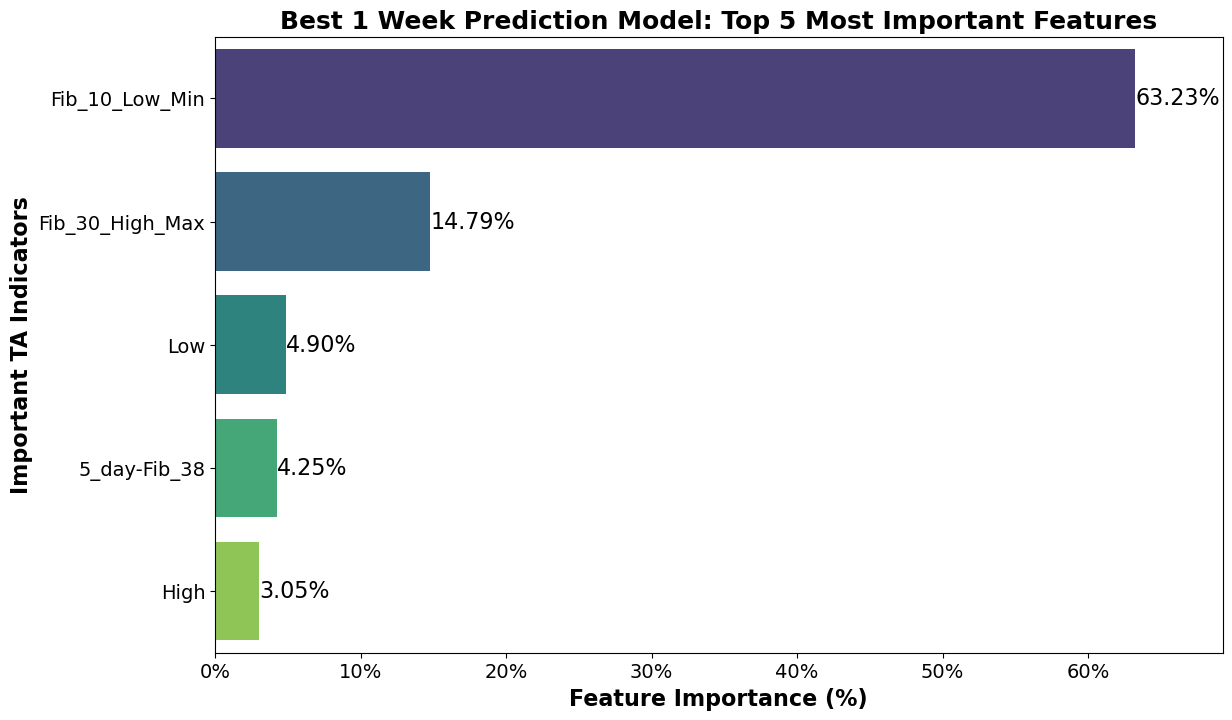

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_week_md_7[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_week_md_7[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Week Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [82]:
# first we will modify our feature set to add bigger lagging indicators.
# Create a new dataframe called 'df_stock_data_1_month' as a copy of 'df_stocks_price_ta'
df_stock_data_1_month = df_stocks_price_ta.copy()


In [83]:
# List of columns to create lags for (focusing on short-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume', 'EMA_12_MACD', 'SMA_20', 'EMA_20']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 12, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7, 10, 12, 15, 20]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_1_month[f'{col}_lag_{lag}'] = df_stock_data_1_month[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_1_month.head()

,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,SMA_20_lag_15,SMA_20_lag_20,EMA_20_lag_1,EMA_20_lag_3,EMA_20_lag_5,EMA_20_lag_7,EMA_20_lag_10,EMA_20_lag_12,EMA_20_lag_15,EMA_20_lag_20
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,NaN,NaN,10.520000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,NaN,NaN,10.479048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,NaN,NaN,10.454377,10.520000,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,NaN,NaN,10.464436,10.479048,NaN,NaN,NaN,NaN,NaN,NaN


In [271]:
# now we're going to move onto our next model: 1 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_baseline = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_baseline = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_baseline['Close_Target'] = df_stock_data_train_1_month_baseline.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_baseline['Close_Target'] = df_stock_data_test_1_month_baseline.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_baseline = df_stock_data_train_1_month_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_baseline = df_stock_data_test_1_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_baseline[numeric_cols_train] = df_stock_data_train_1_month_baseline[numeric_cols_train].fillna(df_stock_data_train_1_month_baseline[numeric_cols_train].median())
df_stock_data_test_1_month_baseline[numeric_cols_test] = df_stock_data_test_1_month_baseline[numeric_cols_test].fillna(df_stock_data_test_1_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_month_baseline = df_stock_data_train_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_baseline = df_stock_data_train_1_month_baseline['Close_Target']

# Create X and y for testing
X_test_1_month_baseline = df_stock_data_test_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_baseline = df_stock_data_test_1_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_baseline shape: {X_train_1_month_baseline.shape}, y_train_1_month_baseline shape: {y_train_1_month_baseline.shape}")
print(f"X_test_1_month_baseline shape: {X_test_1_month_baseline.shape}, y_test_1_month_baseline shape: {y_test_1_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_baseline.shape[0] == 0 or X_test_1_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_month.fit(X_train_1_month_baseline, y_train_1_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_baseline = model_baseline_1_month.predict(X_test_1_month_baseline)

# Calculate performance on the test data
mse_test_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_baseline}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/4202375805.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_baseline['Close_Target'] = df_stock_data_train_1_month_baseline.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/4202375805.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_baseline['Close_Target'] = df_stock_data_test_1_month_baseline.groupby('Symbol')['Close'].shift(-

Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_baseline shape: (804275, 107), y_train_1_month_baseline shape: (804275,)
X_test_1_month_baseline shape: (412225, 107), y_test_1_month_baseline shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 11580.595262448778


In [272]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_baseline` are your predictions for the test data and `y_test_1_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
mae_1_month_baseline = mean_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
rmse_1_month_baseline = np.sqrt(mse_1_month_baseline)  # Root Mean Squared Error
r2_1_month_baseline = r2_score(y_test_1_month_baseline, y_pred_1_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_baseline}')
print(f'R-squared on unseen data: {r2_1_month_baseline}')

# Additional metrics
medae_1_month_baseline = median_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_month_baseline}')

dw_stat_1_month_baseline = durbin_watson(y_test_1_month_baseline - y_pred_1_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_baseline = np.mean(np.abs((y_test_1_month_baseline - y_pred_1_month_baseline) / y_test_1_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_baseline = dict(zip(X_train_1_month_baseline.columns, model_baseline_1_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_baseline = sorted(feature_importance_1_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 11580.595262448778
Mean Absolute Error on unseen data: 16.106877200112017
Root Mean Squared Error on unseen data: 107.61317420487502
R-squared on unseen data: 0.9480862120608777
Median Absolute Error on unseen data: 3.451629638671875
Durbin-Watson Statistic on unseen data: 0.07080939887518617
MAPE on unseen data: 7.98%
Fib_30_High_Max: 35.64%
30_day_Fib_23: 31.34%
High: 5.57%
Fib_30_Low_Min: 5.56%
Low: 5.24%
EMA_5: 3.63%
30_day_Fib_50: 2.97%
Volume: 2.96%
Fib_5_Low_Min: 1.49%
Fib_5_High_Max: 0.85%
EMA_26_MACD: 0.55%
10_day_Fib_38: 0.52%
ATR_Prev_Close: 0.41%
Fib_10_Low_Min: 0.40%
5_day-Fib_23: 0.36%
SMA_5: 0.35%
VWAP: 0.35%
Cumulative_Price_Volume: 0.29%
Std_Dev: 0.21%
Fib_10_High_Max: 0.21%
Lower_Band: 0.15%
ATR_True_Range: 0.12%
30_day_Fib_61: 0.11%
EMA_50: 0.09%
SMA_50: 0.09%
ATR: 0.06%
Upper_Band: 0.06%
Cumulative_Volume: 0.05%
EMA_20_lag_20: 0.04%
SMA_5_lag_15: 0.04%
EMA_12_MACD_lag_12: 0.03%
Volume_lag_1: 0.03%
Volume_lag_20: 0.02%
ATR_High_Low:

In [86]:
# Get feature importance from the baseline model (1-week prediction)
feature_importance = dict(zip(X_train.columns, model_baseline_1_month.feature_importances_))

# Filter features with importance greater than 1%
important_features = {feature: importance for feature, importance in feature_importance.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names (keys) into a list
important_feature_names = [feature for feature, importance in sorted_important_features]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names)




Features with more than 1% contribution:
Fib_30_High_Max: 35.64%
30_day_Fib_23: 31.34%
High: 5.57%
Fib_30_Low_Min: 5.56%
Low: 5.24%
EMA_5: 3.63%
30_day_Fib_50: 2.97%
Volume: 2.96%
Fib_5_Low_Min: 1.49%
List of important features:
['Fib_30_High_Max', '30_day_Fib_23', 'High', 'Fib_30_Low_Min', 'Low', 'EMA_5', '30_day_Fib_50', 'Volume', 'Fib_5_Low_Min']


In [87]:
important_features = ['Symbol', 'Date', 'Close', 'Fib_30_High_Max', '30_day_Fib_23',
                      'High', 'Low', 'Fib_30_Low_Min', 'Volume', 'EMA_5', '30_day_Fib_50',
                      'Fib_5_Low_Min']
df_important_feat_1_month = df_stock_data_1_month[important_features]
df_important_feat_1_month.head()

,Symbol,Date,Close,Fib_30_High_Max,30_day_Fib_23,High,Low,Fib_30_Low_Min,Volume,EMA_5,30_day_Fib_50,Fib_5_Low_Min
171141,A,2022-02-10,50.058052,51.174088,50.877780,51.174088,49.918547,49.918547,1889800.0,50.058052,50.546317,49.918547
171142,A,2022-02-11,47.580647,51.174088,50.244295,49.028604,47.234290,47.234290,3747400.0,49.232250,49.204189,47.234290
171143,A,2022-02-14,47.210232,51.174088,50.140984,47.460380,46.796529,46.796529,3157800.0,48.558244,48.985308,46.796529
171144,A,2022-02-15,48.759216,51.174088,50.140984,49.153677,48.427291,46.796529,1900000.0,48.625235,48.985308,46.796529
171145,A,2022-02-16,49.629917,51.174088,50.140984,49.716506,48.855427,46.796529,2010600.0,48.960129,48.985308,46.796529


In [273]:
# baseline 1 month prediction model with only features contributing over 1%
# not as good as baseline
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_important_feat_1_month = df_important_feat_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_if = df_important_feat_1_month[df_important_feat_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_if = df_important_feat_1_month[df_important_feat_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_if.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_if['Close_Target'] = df_stock_data_train_1_month_if.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_if['Close_Target'] = df_stock_data_test_1_month_if.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_if = df_stock_data_train_1_month_if.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_if = df_stock_data_test_1_month_if.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_if.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_if.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_if[numeric_cols_train] = df_stock_data_train_1_month_if[numeric_cols_train].fillna(df_stock_data_train_1_month_if[numeric_cols_train].median())
df_stock_data_test_1_month_if[numeric_cols_test] = df_stock_data_test_1_month_if[numeric_cols_test].fillna(df_stock_data_test_1_month_if[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_if.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_if.shape}")

# Create X (features) and y (target) for training
X_train_1_month_if = df_stock_data_train_1_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_if = df_stock_data_train_1_month_if['Close_Target']

# Create X and y for testing
X_test_1_month_if = df_stock_data_test_1_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_if = df_stock_data_test_1_month_if['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_if shape: {X_train_1_month_if.shape}, y_train_1_month_if shape: {y_train_1_month_if.shape}")
print(f"X_test_1_month_if shape: {X_test_1_month_if.shape}, y_test_1_month_if shape: {y_test_1_month_if.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_if.shape[0] == 0 or X_test_1_month_if.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_if_1_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_if_1_month.fit(X_train_1_month_if, y_train_1_month_if)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_if = model_baseline_if_1_month.predict(X_test_1_month_if)

# Calculate performance on the test data
mse_test_1_month_if = mean_squared_error(y_test_1_month_if, y_pred_1_month_if)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_if}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/932682732.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_if['Close_Target'] = df_stock_data_train_1_month_if.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/932682732.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_if['Close_Target'] = df_stock_data_test_1_month_if.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 13)
Testing data shape: (412225, 13)
X_train_1_month_if shape: (804275, 9), y_train_1_month_if shape: (804275,)
X_test_1_month_if shape: (412225, 9), y_test_1_month_if shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 32079.230668815384


In [274]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_if` are your predictions for the test data and `y_test_1_month_if` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_if = mean_squared_error(y_test_1_month_if, y_pred_1_month_if)
mae_1_month_if = mean_absolute_error(y_test_1_month_if, y_pred_1_month_if)
rmse_1_month_if = np.sqrt(mse_1_month_if)  # Root Mean Squared Error
r2_1_month_if = r2_score(y_test_1_month_if, y_pred_1_month_if)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_if}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_if}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_if}')
print(f'R-squared on unseen data: {r2_1_month_if}')

# Additional metrics
medae_1_month_if = median_absolute_error(y_test_1_month_if, y_pred_1_month_if)
print(f'Median Absolute Error on unseen data: {medae_1_month_if}')

dw_stat_1_month_if = durbin_watson(y_test_1_month_if - y_pred_1_month_if)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_if}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_if = np.mean(np.abs((y_test_1_month_if - y_pred_1_month_if) / y_test_1_month_if)) * 100
print(f'MAPE on unseen data: {mape_1_month_if:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_if = dict(zip(X_train_1_month_if.columns, model_baseline_if_1_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_if = sorted(feature_importance_1_month_if.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_if:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 32079.230668815384
Mean Absolute Error on unseen data: 21.58220780969353
Root Mean Squared Error on unseen data: 179.10675774189923
R-squared on unseen data: 0.8561944062071536
Median Absolute Error on unseen data: 3.2651214599609375
Durbin-Watson Statistic on unseen data: 0.04222523242030978
MAPE on unseen data: 7.63%
Fib_30_High_Max: 38.32%
30_day_Fib_23: 25.10%
High: 12.95%
Low: 11.06%
Fib_30_Low_Min: 5.84%
Volume: 2.25%
30_day_Fib_50: 1.67%
EMA_5: 1.61%
Fib_5_Low_Min: 1.19%


In [275]:
# 1 month baseline model with learning_rate=0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_lr_1 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_lr_1 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_lr_1['Close_Target'] = df_stock_data_train_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_lr_1['Close_Target'] = df_stock_data_test_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_lr_1 = df_stock_data_train_1_month_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_lr_1 = df_stock_data_test_1_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_lr_1[numeric_cols_train] = df_stock_data_train_1_month_lr_1[numeric_cols_train].fillna(df_stock_data_train_1_month_lr_1[numeric_cols_train].median())
df_stock_data_test_1_month_lr_1[numeric_cols_test] = df_stock_data_test_1_month_lr_1[numeric_cols_test].fillna(df_stock_data_test_1_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_1 = df_stock_data_train_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_1 = df_stock_data_train_1_month_lr_1['Close_Target']

# Create X and y for testing
X_test_1_month_lr_1 = df_stock_data_test_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_1 = df_stock_data_test_1_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_1 shape: {X_train_1_month_lr_1.shape}, y_train_1_month_lr_1 shape: {y_train_1_month_lr_1.shape}")
print(f"X_test_1_month_lr_1 shape: {X_test_1_month_lr_1.shape}, y_test_1_month_lr_1 shape: {y_test_1_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_1.shape[0] == 0 or X_test_1_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_tr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_tr_01.fit(X_train_1_month_lr_1, y_train_1_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_1 = model_1_month_tr_01.predict(X_test_1_month_lr_1)

# Calculate performance on the test data
mse_test_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_1}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/52133327.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_lr_1['Close_Target'] = df_stock_data_train_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/52133327.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_lr_1['Close_Target'] = df_stock_data_test_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_lr_1 shape: (804275, 107), y_train_1_month_lr_1 shape: (804275,)
X_test_1_month_lr_1 shape: (412225, 107), y_test_1_month_lr_1 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 12131.686683682172


In [276]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_lr_1` are your predictions for the test data and `y_test_1_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
mae_1_month_lr_1 = mean_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
rmse_1_month_lr_1 = np.sqrt(mse_1_month_lr_1)  # Root Mean Squared Error
r2_1_month_lr_1 = r2_score(y_test_1_month_lr_1, y_pred_1_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_lr_1}')
print(f'R-squared on unseen data: {r2_1_month_lr_1}')

# Additional metrics
medae_1_month_lr_1 = median_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_1}')

dw_stat_1_month_lr_1 = durbin_watson(y_test_1_month_lr_1 - y_pred_1_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_1 = np.mean(np.abs((y_test_1_month_lr_1 - y_pred_1_month_lr_1) / y_test_1_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_lr_1 = dict(zip(X_train_1_month_lr_1.columns, model_1_month_tr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_1 = sorted(feature_importance_1_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12131.686683682172
Mean Absolute Error on unseen data: 16.7761954501155
Root Mean Squared Error on unseen data: 110.14393620931736
R-squared on unseen data: 0.9456157653758314
Median Absolute Error on unseen data: 3.590789794921875
Durbin-Watson Statistic on unseen data: 0.06393498702616922
MAPE on unseen data: 8.30%
Fib_30_High_Max: 39.63%
30_day_Fib_23: 25.74%
Low: 6.83%
High: 6.59%
Fib_30_Low_Min: 4.69%
30_day_Fib_50: 4.25%
Volume: 3.47%
EMA_5: 2.92%
Fib_5_Low_Min: 0.77%
Fib_10_Low_Min: 0.64%
Fib_5_High_Max: 0.63%
10_day_Fib_38: 0.57%
ATR_Prev_Close: 0.54%
EMA_26_MACD: 0.53%
Cumulative_Price_Volume: 0.36%
VWAP: 0.35%
Std_Dev: 0.24%
Lower_Band: 0.15%
5_day-Fib_23: 0.15%
ATR_True_Range: 0.14%
EMA_50: 0.08%
Cumulative_Volume: 0.05%
ATR: 0.05%
SMA_5_lag_15: 0.05%
30_day_Fib_38: 0.05%
SMA_50: 0.05%
30_day_Fib_61: 0.05%
EMA_20_lag_20: 0.04%
Upper_Band: 0.04%
Volume_lag_1: 0.03%
Fib_10_High_Max: 0.03%
EMA_12_MACD_lag_12: 0.02%
ATR_High_Low: 0.01%
Volume_l

In [277]:
# 1 month baseline model with learning_rate=0.01
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_lr_01 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_lr_01 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_lr_01['Close_Target'] = df_stock_data_train_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_lr_01['Close_Target'] = df_stock_data_test_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_lr_01 = df_stock_data_train_1_month_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_lr_01 = df_stock_data_test_1_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_lr_01[numeric_cols_train] = df_stock_data_train_1_month_lr_01[numeric_cols_train].fillna(df_stock_data_train_1_month_lr_01[numeric_cols_train].median())
df_stock_data_test_1_month_lr_01[numeric_cols_test] = df_stock_data_test_1_month_lr_01[numeric_cols_test].fillna(df_stock_data_test_1_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_01 = df_stock_data_train_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_01 = df_stock_data_train_1_month_lr_01['Close_Target']

# Create X and y for testing
X_test_1_month_lr_01 = df_stock_data_test_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_01 = df_stock_data_test_1_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_01 shape: {X_train_1_month_lr_01.shape}, y_train_1_month_lr_01 shape: {y_train_1_month_lr_01.shape}")
print(f"X_test_1_month_lr_01 shape: {X_test_1_month_lr_01.shape}, y_test_1_month_lr_01 shape: {y_test_1_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_01.shape[0] == 0 or X_test_1_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_tr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_tr_1.fit(X_train_1_month_lr_01, y_train_1_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_01 = model_1_month_tr_1.predict(X_test_1_month_lr_01)

# Calculate performance on the test data
mse_test_1_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_01}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1410818009.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_lr_01['Close_Target'] = df_stock_data_train_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1410818009.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_lr_01['Close_Target'] = df_stock_data_test_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_lr_01 shape: (804275, 107), y_train_1_month_lr_01 shape: (804275,)
X_test_1_month_lr_01 shape: (412225, 107), y_test_1_month_lr_01 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 11047.206778467535


In [278]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_lr_01` are your predictions for the test data and `y_test_1_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
mae_1_month_lr_01 = mean_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
rmse_month_lr_01 = np.sqrt(mse_month_lr_01)  # Root Mean Squared Error
r2_month_lr_01 = r2_score(y_test_1_month_lr_01, y_pred_1_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_month_lr_01}')
print(f'R-squared on unseen data: {r2_month_lr_01}')

# Additional metrics
medae_1_month_lr_01 = median_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_01}')

dw_stat_1_month_lr_01 = durbin_watson(y_test_1_month_lr_01 - y_pred_1_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_01 = np.mean(np.abs((y_test_1_month_lr_01 - y_pred_1_month_lr_01) / y_test_1_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_month_lr_01 = dict(zip(X_train_1_month_lr_01.columns, model_1_month_tr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_01 = sorted(feature_importance_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 11047.206778467535
Mean Absolute Error on unseen data: 15.37042669814166
Root Mean Squared Error on unseen data: 105.10569336847331
R-squared on unseen data: 0.9504772995670925
Median Absolute Error on unseen data: 3.3103179931640625
Durbin-Watson Statistic on unseen data: 0.07154779960843687
MAPE on unseen data: 8.15%
Fib_30_High_Max: 39.63%
30_day_Fib_23: 25.74%
Low: 6.83%
High: 6.59%
Fib_30_Low_Min: 4.69%
30_day_Fib_50: 4.25%
Volume: 3.47%
EMA_5: 2.92%
Fib_5_Low_Min: 0.77%
Fib_10_Low_Min: 0.64%
Fib_5_High_Max: 0.63%
10_day_Fib_38: 0.57%
ATR_Prev_Close: 0.54%
EMA_26_MACD: 0.53%
Cumulative_Price_Volume: 0.36%
VWAP: 0.35%
Std_Dev: 0.24%
Lower_Band: 0.15%
5_day-Fib_23: 0.15%
ATR_True_Range: 0.14%
EMA_50: 0.08%
Cumulative_Volume: 0.05%
ATR: 0.05%
SMA_5_lag_15: 0.05%
30_day_Fib_38: 0.05%
SMA_50: 0.05%
30_day_Fib_61: 0.05%
EMA_20_lag_20: 0.04%
Upper_Band: 0.04%
Volume_lag_1: 0.03%
Fib_10_High_Max: 0.03%
EMA_12_MACD_lag_12: 0.02%
ATR_High_Low: 0.01%
Volume

In [279]:
# model with learning_rate = 0.01 is best again, so we keep that parameter
# now we'll do max depth
# max depth = 3
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_md_3 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_md_3 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_md_3['Close_Target'] = df_stock_data_train_1_month_md_3.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_md_3['Close_Target'] = df_stock_data_test_1_month_md_3.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_md_3 = df_stock_data_train_1_month_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_md_3 = df_stock_data_test_1_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_md_3[numeric_cols_train] = df_stock_data_train_1_month_md_3[numeric_cols_train].fillna(df_stock_data_train_1_month_md_3[numeric_cols_train].median())
df_stock_data_test_1_month_md_3[numeric_cols_test] = df_stock_data_test_1_month_md_3[numeric_cols_test].fillna(df_stock_data_test_1_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_3 = df_stock_data_train_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_3 = df_stock_data_train_1_month_md_3['Close_Target']

# Create X and y for testing
X_test_1_month_md_3 = df_stock_data_test_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_3 = df_stock_data_test_1_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_3 shape: {X_train_1_month_md_3.shape}, y_train_1_month_md_3 shape: {y_train_1_month_md_3.shape}")
print(f"X_test_1_month_md_3 shape: {X_test_1_month_md_3.shape}, y_test_1_month_md_3 shape: {y_test_1_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_3.shape[0] == 0 or X_test_1_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_3.fit(X_train_1_month_md_3, y_train_1_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_3 = model_1_month_md_3.predict(X_test_1_month_md_3)

# Calculate performance on the test data
mse_test_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_3}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2069121884.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_md_3['Close_Target'] = df_stock_data_train_1_month_md_3.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2069121884.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_md_3['Close_Target'] = df_stock_data_test_1_month_md_3.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_md_3 shape: (804275, 107), y_train_1_month_md_3 shape: (804275,)
X_test_1_month_md_3 shape: (412225, 107), y_test_1_month_md_3 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 12105.89455732451


In [280]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_md_3` are your predictions for the test data and `y_test_1_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
mae_1_month_md_3 = mean_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
rmse_1_month_md_3 = np.sqrt(mse_1_month_md_3)  # Root Mean Squared Error
r2_1_month_md_3 = r2_score(y_test_1_month_md_3, y_pred_1_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_3}')
print(f'R-squared on unseen data: {r2_1_month_md_3}')

# Additional metrics
medae_1_month_md_3 = median_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_3}')

dw_stat_1_month_md_3 = durbin_watson(y_test_1_month_md_3 - y_pred_1_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_3 = np.mean(np.abs((y_test_1_month_md_3 - y_pred_1_month_md_3) / y_test_1_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_3 = dict(zip(X_train_1_month_md_3.columns, model_1_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_3 = sorted(feature_importance_1_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12105.89455732451
Mean Absolute Error on unseen data: 15.257036908276845
Root Mean Squared Error on unseen data: 110.02679018004892
R-squared on unseen data: 0.9457313869779931
Median Absolute Error on unseen data: 3.3381423950195312
Durbin-Watson Statistic on unseen data: 0.04725178854812182
MAPE on unseen data: 9.04%
Fib_30_High_Max: 46.42%
30_day_Fib_23: 6.82%
Fib_30_Low_Min: 6.65%
Upper_Band: 6.59%
10_day_Fib_50: 5.20%
10_day_Fib_38: 3.55%
Low: 2.03%
Volume: 1.97%
Close_lag_1: 1.91%
High: 1.82%
EMA_20: 1.80%
EMA_5: 1.52%
30_day_Fib_61: 1.43%
Fib_10_Low_Min: 1.35%
EMA_5_lag_15: 1.30%
Fib_5_High_Max: 0.90%
SMA_50: 0.88%
ATR: 0.79%
VWAP: 0.69%
EMA_50: 0.66%
ATR_High_Low: 0.64%
Fib_5_Low_Min: 0.57%
EMA_26_MACD: 0.49%
Fib_10_High_Max: 0.46%
Close_lag_20: 0.43%
30_day_Fib_50: 0.40%
Lower_Band: 0.35%
ATR_True_Range: 0.30%
Volume_lag_1: 0.28%
Std_Dev: 0.26%
ATR_Prev_Close: 0.24%
SMA_20_lag_20: 0.21%
Cumulative_Price_Volume: 0.18%
30_day_Fib_38: 0.13%
Volu

In [265]:
# model with learning_rate = 0.01 is best again, so we keep that parameter
# now we'll do max depth
# max depth = 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_1_month = df_stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
df_stock_data_train_1_month_md_7 = df_stock_data_1_month[df_stock_data_1_month['Date'] <= '2024-01-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_1_month_md_7 = df_stock_data_1_month[df_stock_data_1_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_1_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_1_month_md_7['Close_Target'] = df_stock_data_train_1_month_md_7.groupby('Symbol')['Close'].shift(-20)
df_stock_data_test_1_month_md_7['Close_Target'] = df_stock_data_test_1_month_md_7.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_1_month_md_7 = df_stock_data_train_1_month_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_1_month_md_7 = df_stock_data_test_1_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_1_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_1_month_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_1_month_md_7[numeric_cols_train] = df_stock_data_train_1_month_md_7[numeric_cols_train].fillna(df_stock_data_train_1_month_md_7[numeric_cols_train].median())
df_stock_data_test_1_month_md_7[numeric_cols_test] = df_stock_data_test_1_month_md_7[numeric_cols_test].fillna(df_stock_data_test_1_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_1_month_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_1_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_7 = df_stock_data_train_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_7 = df_stock_data_train_1_month_md_7['Close_Target']

# Create X and y for testing
X_test_1_month_md_7 = df_stock_data_test_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_7 = df_stock_data_test_1_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_7 shape: {X_train_1_month_md_7.shape}, y_train_1_month_md_7 shape: {y_train_1_month_md_7.shape}")
print(f"X_test_1_month_md_7 shape: {X_test_1_month_md_7.shape}, y_test_1_month_md_7 shape: {y_test_1_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_7.shape[0] == 0 or X_test_1_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_7.fit(X_train_1_month_md_7, y_train_1_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_7 = model_1_month_md_7.predict(X_test_1_month_md_7)

# Calculate performance on the test data
mse_test_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_7}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3558892380.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_1_month_md_7['Close_Target'] = df_stock_data_train_1_month_md_7.groupby('Symbol')['Close'].shift(-20)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3558892380.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_1_month_md_7['Close_Target'] = df_stock_data_test_1_month_md_7.groupby('Symbol')['Close'].shift(-20)


Training data shape: (804275, 111)
Testing data shape: (412225, 111)
X_train_1_month_md_7 shape: (804275, 107), y_train_1_month_md_7 shape: (804275,)
X_test_1_month_md_7 shape: (412225, 107), y_test_1_month_md_7 shape: (412225,)
Mean Squared Error on unseen data (post-February 10, 2024): 10844.724459170979


In [266]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_md_7` are your predictions for the test data and `y_test_1_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
mae_1_month_md_7 = mean_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
rmse_1_month_md_7 = np.sqrt(mse_1_month_md_7)  # Root Mean Squared Error
r2_1_month_md_7 = r2_score(y_test_1_month_md_7, y_pred_1_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_7}')
print(f'R-squared on unseen data: {r2_1_month_md_7}')

# Additional metrics
medae_1_month_md_7 = median_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_7}')

dw_stat_1_month_md_7 = durbin_watson(y_test_1_month_md_7 - y_pred_1_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_7 = np.mean(np.abs((y_test_1_month_md_7 - y_pred_1_month_md_7) / y_test_1_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_7 = dict(zip(X_train_1_month_md_7.columns, model_1_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_7 = sorted(feature_importance_1_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 10844.724459170979
Mean Absolute Error on unseen data: 15.639166248218757
Root Mean Squared Error on unseen data: 104.13800679469037
R-squared on unseen data: 0.9513849924746814
Median Absolute Error on unseen data: 3.326946258544922
Durbin-Watson Statistic on unseen data: 0.0750817215794377
MAPE on unseen data: 7.82%
30_day_Fib_23: 52.41%
Fib_30_High_Max: 32.44%
Fib_5_Low_Min: 2.25%
Low: 2.08%
10_day_Fib_23: 1.96%
High: 1.77%
Volume: 1.43%
5_day-Fib_50: 1.11%
30_day_Fib_50: 0.68%
10_day_Fib_38: 0.62%
5_day-Fib_23: 0.48%
Fib_10_High_Max: 0.28%
Fib_10_Low_Min: 0.25%
Std_Dev: 0.21%
VWAP: 0.21%
ATR_Prev_Close: 0.20%
EMA_5: 0.19%
Fib_5_High_Max: 0.19%
Cumulative_Price_Volume: 0.17%
Lower_Band: 0.16%
EMA_26_MACD: 0.14%
30_day_Fib_61: 0.11%
SMA_5: 0.11%
SMA_20_lag_1: 0.06%
Upper_Band: 0.05%
5_day-Fib_61: 0.04%
ATR_True_Range: 0.04%
Cumulative_Volume: 0.04%
30_day_Fib_38: 0.03%
10_day_Fib_61: 0.03%
EMA_50: 0.02%
Fib_30_Low_Min: 0.02%
ATR: 0.02%
Volume_lag_1:

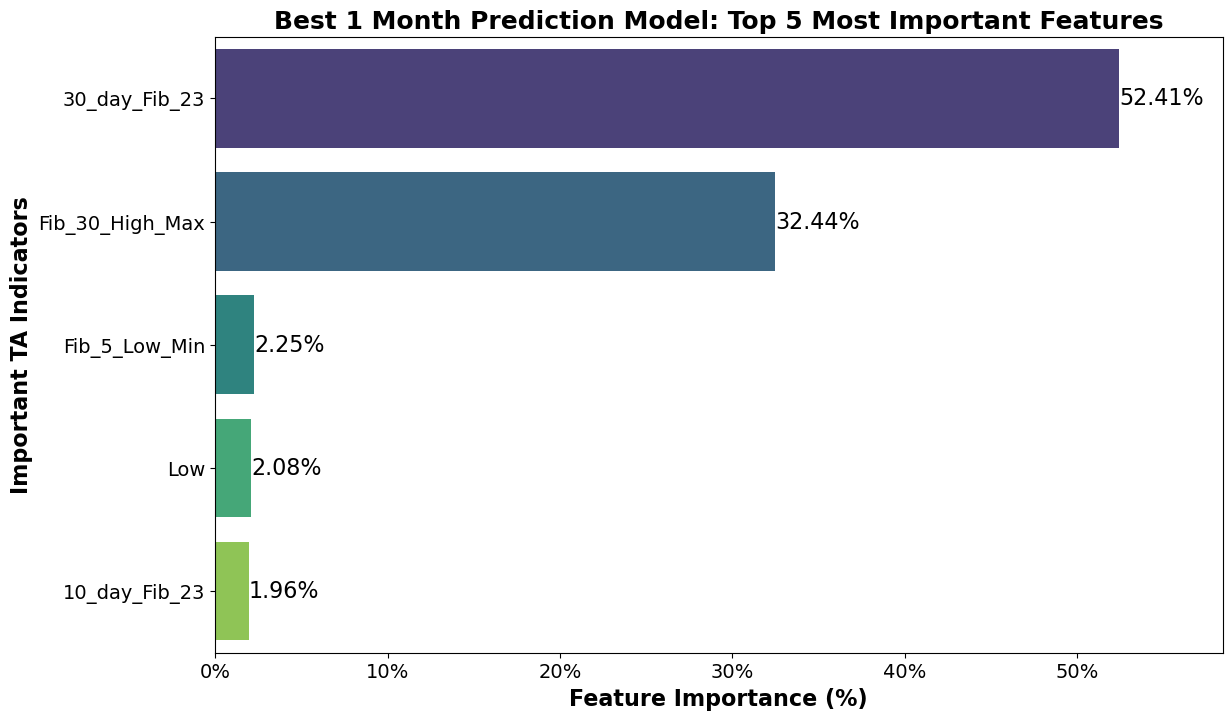

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_month_md_7[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_month_md_7[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [99]:
# first we will modify our feature set to add bigger lagging indicators.
# Create a new dataframe called 'df_stock_data_3_month' as a copy of 'df_stocks_price_ta'
df_stock_data_3_month = df_stocks_price_ta.copy()


In [100]:
# List of columns to create lags for (focusing on mid-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume', 'SMA_20',
       'SMA_50', 'EMA_5', 'EMA_20', 'EMA_50',  'EMA_12_MACD',
       'EMA_26_MACD']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 12, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_3_month[f'{col}_lag_{lag}'] = df_stock_data_3_month[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_3_month.head()



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2984211339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_3_month[f'{col}_lag_{lag}'] = df_stock_data_3_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2984211339.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_3_month[f'{col}_lag_{lag}'] = df_stock_data_3_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2984211339.py:13: PerformanceWarning: DataFrame

,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,EMA_26_MACD_lag_10,EMA_26_MACD_lag_15,EMA_26_MACD_lag_20,EMA_26_MACD_lag_25,EMA_26_MACD_lag_30,EMA_26_MACD_lag_40,EMA_26_MACD_lag_50,EMA_26_MACD_lag_60,EMA_26_MACD_lag_75,EMA_26_MACD_lag_90
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
# now we're going to move onto our next model: 3 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_baseline = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_baseline = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_baseline['Close_Target'] = df_stock_data_train_3_month_baseline.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_baseline['Close_Target'] = df_stock_data_test_3_month_baseline.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_baseline = df_stock_data_train_3_month_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_baseline = df_stock_data_test_3_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_baseline[numeric_cols_train] = df_stock_data_train_3_month_baseline[numeric_cols_train].fillna(df_stock_data_train_3_month_baseline[numeric_cols_train].median())
df_stock_data_test_3_month_baseline[numeric_cols_test] = df_stock_data_test_3_month_baseline[numeric_cols_test].fillna(df_stock_data_test_3_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_3_month_baseline = df_stock_data_train_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_baseline = df_stock_data_train_3_month_baseline['Close_Target']

# Create X and y for testing
X_test_3_month_baseline = df_stock_data_test_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_baseline = df_stock_data_test_3_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_baseline shape: {X_train_3_month_baseline.shape}, y_train_3_month_baseline shape: {y_train_3_month_baseline.shape}")
print(f"X_test_3_month_baseline shape: {X_test_3_month_baseline.shape}, y_test_3_month_baseline shape: {y_test_3_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_baseline.shape[0] == 0 or X_test_3_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_3_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_3_month.fit(X_train_3_month_baseline, y_train_3_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_baseline = model_baseline_3_month.predict(X_test_3_month_baseline)

# Calculate performance on the test data
mse_test_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_baseline}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/231090126.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_baseline['Close_Target'] = df_stock_data_train_3_month_baseline.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/231090126.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_baseline['Close_Target'] = df_stock_data_test_3_month_baseline.groupby('Symbol')['Close'].shift(-60

Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_baseline shape: (664084, 191), y_train_3_month_baseline shape: (664084,)
X_test_3_month_baseline shape: (340665, 191), y_test_3_month_baseline shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 31301.74125575056


In [241]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_baseline` are your predictions for the test data and `y_test_3_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
mae_3_month_baseline = mean_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
rmse_3_month_baseline = np.sqrt(mse)  # Root Mean Squared Error
r2_3_month_baseline = r2_score(y_test_3_month_baseline, y_pred_3_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_baseline}')
print(f'R-squared on unseen data: {r2_3_month_baseline}')

# Additional metrics
medae_3_month_baseline = median_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_3_month_baseline}')

dw_stat_3_month_baseline = durbin_watson(y_test_3_month_baseline - y_pred_3_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_baseline = np.mean(np.abs((y_test_3_month_baseline - y_pred_3_month_baseline) / y_test_3_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_3_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_baseline = dict(zip(X_train_3_month_baseline.columns, model_baseline_3_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_baseline = sorted(feature_importance_3_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 31301.74125575056
Mean Absolute Error on unseen data: 28.611355863536343
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.8648566403012485
Median Absolute Error on unseen data: 6.425842285156236
Durbin-Watson Statistic on unseen data: 0.01850750963651389
MAPE on unseen data: 14.09%
Fib_30_Low_Min: 33.56%
30_day_Fib_38: 19.87%
5_day-Fib_61: 12.35%
EMA_5: 5.42%
5_day-Fib_23: 5.20%
EMA_12_MACD: 4.18%
Volume: 2.75%
High: 2.65%
Low: 2.18%
30_day_Fib_61: 1.74%
ATR_Prev_Close: 1.21%
Fib_5_Low_Min: 1.01%
Close_lag_1: 0.99%
30_day_Fib_50: 0.83%
EMA_26_MACD: 0.72%
Upper_Band: 0.57%
VWAP: 0.49%
Lower_Band: 0.40%
EMA_20: 0.37%
Std_Dev: 0.29%
SMA_5_lag_90: 0.23%
SMA_50: 0.23%
Fib_30_High_Max: 0.20%
Fib_5_High_Max: 0.20%
10_day_Fib_50: 0.20%
Cumulative_Price_Volume: 0.19%
EMA_50_lag_7: 0.15%
Fib_10_Low_Min: 0.14%
ATR_True_Range: 0.12%
Fib_10_High_Max: 0.09%
ATR_High_Low: 0.07%
EMA_50_lag_20: 0.06%
EMA_50_lag_60: 0.06%
EMA_50_la

In [103]:
# Get feature importance from the baseline model (1-week prediction)
feature_importance = dict(zip(X_train.columns, model_baseline_3_month.feature_importances_))

# Filter features with importance greater than 1%
important_features = {feature: importance for feature, importance in feature_importance.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names (keys) into a list
important_feature_names = [feature for feature, importance in sorted_important_features]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names)


Features with more than 1% contribution:
Fib_30_Low_Min: 33.56%
30_day_Fib_38: 19.87%
5_day-Fib_61: 12.35%
EMA_5: 5.42%
5_day-Fib_23: 5.20%
EMA_12_MACD: 4.18%
Volume: 2.75%
High: 2.65%
Low: 2.18%
30_day_Fib_61: 1.74%
ATR_Prev_Close: 1.21%
Fib_5_Low_Min: 1.01%
List of important features:
['Fib_30_Low_Min', '30_day_Fib_38', '5_day-Fib_61', 'EMA_5', '5_day-Fib_23', 'EMA_12_MACD', 'Volume', 'High', 'Low', '30_day_Fib_61', 'ATR_Prev_Close', 'Fib_5_Low_Min']


In [105]:
important_features = ['Symbol', 'Date', 'Close', 'Fib_30_Low_Min', '30_day_Fib_38',
                      '5_day-Fib_61', '5_day-Fib_23', 'EMA_5', 'Volume',
                      'EMA_12_MACD', 'High', 'Low', '30_day_Fib_61',
                      'ATR_Prev_Close', 'Fib_5_Low_Min']
df_important_feat_3_month = df_stock_data_3_month[important_features]
df_important_feat_3_month.head()

,Symbol,Date,Close,Fib_30_Low_Min,30_day_Fib_38,5_day-Fib_61,5_day-Fib_23,EMA_5,Volume,EMA_12_MACD,High,Low,30_day_Fib_61,ATR_Prev_Close,Fib_5_Low_Min
171141,A,2022-02-10,50.058052,49.918547,50.694471,50.398164,50.877780,50.058052,1889800.0,50.058052,51.174088,49.918547,50.398164,NaN,49.918547
171142,A,2022-02-11,47.580647,47.234290,49.669085,48.739293,50.244295,49.232250,3747400.0,49.676913,49.028604,47.234290,48.739293,50.058052,47.234290
171143,A,2022-02-14,47.210232,46.796529,49.501860,48.468756,50.140984,48.558244,3157800.0,49.297423,47.460380,46.796529,48.468756,47.580647,46.796529
171144,A,2022-02-15,48.759216,46.796529,49.501860,48.468756,50.140984,48.625235,1900000.0,49.214622,49.153677,48.427291,48.468756,47.210232,46.796529
171145,A,2022-02-16,49.629917,46.796529,49.501860,48.468756,50.140984,48.960129,2010600.0,49.278514,49.716506,48.855427,48.468756,48.759216,46.796529


In [242]:
# 3 month prediction with only important featuers
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_important_feat_3_month = df_important_feat_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_if = df_important_feat_3_month[df_important_feat_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_if = df_important_feat_3_month[df_important_feat_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_if.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_if['Close_Target'] = df_stock_data_train_3_month_if.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_if['Close_Target'] = df_stock_data_test_3_month_if.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_if = df_stock_data_train_3_month_if.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_if = df_stock_data_test_3_month_if.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_if.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_if.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_if.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_if[numeric_cols_train] = df_stock_data_train_3_month_if[numeric_cols_train].fillna(df_stock_data_train_3_month_if[numeric_cols_train].median())
df_stock_data_test_3_month_if[numeric_cols_test] = df_stock_data_test_3_month_if[numeric_cols_test].fillna(df_stock_data_test_3_month_if[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_if.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_if.shape}")

# Create X (features) and y (target) for training
X_train_3_month_if = df_stock_data_train_3_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_if = df_stock_data_train_3_month_if['Close_Target']

# Create X and y for testing
X_test_3_month_if = df_stock_data_test_3_month_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_if = df_stock_data_test_3_month_if['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_if shape: {X_train_3_month_if.shape}, y_train_3_month_if shape: {y_train_3_month_if.shape}")
print(f"X_test_3_month_if shape: {X_test_3_month_if.shape}, y_test_3_month_if shape: {y_test_3_month_if.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_if.shape[0] == 0 or X_test_3_month_if.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_if_3_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_if_3_month.fit(X_train_3_month_if, y_train_3_month_if)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_if = model_baseline_if_3_month.predict(X_test_3_month_if)

# Calculate performance on the test data
mse_test_3_month_if = mean_squared_error(y_test_3_month_if, y_pred_3_month_if)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_if}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1790160588.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_if['Close_Target'] = df_stock_data_train_3_month_if.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1790160588.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_if['Close_Target'] = df_stock_data_test_3_month_if.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 16)
Testing data shape: (340665, 16)
X_train_3_month_if shape: (664084, 12), y_train_3_month_if shape: (664084,)
X_test_3_month_if shape: (340665, 12), y_test_3_month_if shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 38805.08580927107


In [243]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_if` are your predictions for the test data and `y_test_3_month_if` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_if = mean_squared_error(y_test_3_month_if, y_pred_3_month_if)
mae_3_month_if = mean_absolute_error(y_test_3_month_if, y_pred_3_month_if)
rmse_3_month_if = np.sqrt(mse_3_month_if)  # Root Mean Squared Error
r2_3_month_if = r2_score(y_test_3_month_if, y_pred_3_month_if)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_if}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_if}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_if}')
print(f'R-squared on unseen data: {r2_3_month_if}')

# Additional metrics
medae_3_month_if = median_absolute_error(y_test_3_month_if, y_pred_3_month_if)
print(f'Median Absolute Error on unseen data: {medae_3_month_if}')

dw_stat_3_month_if = durbin_watson(y_test_3_month_if - y_pred_3_month_if)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_if}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_if = np.mean(np.abs((y_test_3_month_if - y_pred_3_month_if) / y_test_3_month_if)) * 100
print(f'MAPE on unseen data: {mape_3_month_if:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_if = dict(zip(X_train_3_month_if.columns, model_baseline_if_3_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_if = sorted(feature_importance_3_month_if.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_if:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 38805.08580927107
Mean Absolute Error on unseen data: 29.90465695916755
Root Mean Squared Error on unseen data: 196.99006525525868
R-squared on unseen data: 0.8324614075998154
Median Absolute Error on unseen data: 6.2861328125
Durbin-Watson Statistic on unseen data: 0.040873685600318704
MAPE on unseen data: 13.25%
Fib_30_Low_Min: 41.10%
High: 16.47%
Low: 11.00%
30_day_Fib_38: 8.28%
EMA_5: 4.93%
ATR_Prev_Close: 3.57%
5_day-Fib_23: 3.51%
Volume: 2.92%
30_day_Fib_61: 2.84%
5_day-Fib_61: 2.61%
EMA_12_MACD: 1.87%
Fib_5_Low_Min: 0.91%


In [244]:
# learning rate = 0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_lr_1 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_lr_1 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_lr_1['Close_Target'] = df_stock_data_train_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_lr_1['Close_Target'] = df_stock_data_test_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_lr_1 = df_stock_data_train_3_month_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_lr_1 = df_stock_data_test_3_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_lr_1[numeric_cols_train] = df_stock_data_train_3_month_lr_1[numeric_cols_train].fillna(df_stock_data_train_3_month_lr_1[numeric_cols_train].median())
df_stock_data_test_3_month_lr_1[numeric_cols_test] = df_stock_data_test_3_month_lr_1[numeric_cols_test].fillna(df_stock_data_test_3_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_1 = df_stock_data_train_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_1 = df_stock_data_train_3_month_lr_1['Close_Target']

# Create X and y for testing
X_test_3_month_lr_1 = df_stock_data_test_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_1 = df_stock_data_test_3_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_1 shape: {X_train_3_month_lr_1.shape}, y_train_3_month_lr_1 shape: {y_train_3_month_lr_1.shape}")
print(f"X_test_3_month_lr_1 shape: {X_test_3_month_lr_1.shape}, y_test_3_month_lr_1 shape: {y_test_3_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_1.shape[0] == 0 or X_test_3_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_tf_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_tf_1.fit(X_train_3_month_lr_1, y_train_3_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_1 = model_3_month_tf_1.predict(X_test_3_month_lr_1)

# Calculate performance on the test data
mse_test_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_1}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3132509529.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_lr_1['Close_Target'] = df_stock_data_train_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3132509529.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_lr_1['Close_Target'] = df_stock_data_test_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_lr_1 shape: (664084, 191), y_train_3_month_lr_1 shape: (664084,)
X_test_3_month_lr_1 shape: (340665, 191), y_test_3_month_lr_1 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 30689.514705268604


In [246]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_1` are your predictions for the test data and `y_test_3_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
mae_3_month_lr_1 = mean_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
rmse_3_month_lr_1 = np.sqrt(mse_3_month_lr_1)  # Root Mean Squared Error
r2_3_month_lr_1 = r2_score(y_test_3_month_lr_1, y_pred_3_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_1}')
print(f'R-squared on unseen data: {r2_3_month_lr_1}')

# Additional metrics
medae_3_month_lr_1 = median_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_1}')

dw_stat_3_month_lr_1 = durbin_watson(y_test_3_month_lr_1 - y_pred_3_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_1 = np.mean(np.abs((y_test_3_month_lr_1 - y_pred_3_month_lr_1) / y_test_3_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_1 = dict(zip(X_train_3_month_lr_1.columns, model_3_month_tf_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_1 = sorted(feature_importance_3_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 30689.514705268604
Mean Absolute Error on unseen data: 29.242334413401167
Root Mean Squared Error on unseen data: 175.18423075513562
R-squared on unseen data: 0.867499891111256
Median Absolute Error on unseen data: 6.841819763183594
Durbin-Watson Statistic on unseen data: 0.018820913363933614
MAPE on unseen data: 14.94%
Fib_30_Low_Min: 30.03%
30_day_Fib_38: 23.30%
5_day-Fib_61: 11.28%
EMA_5: 8.27%
5_day-Fib_23: 6.93%
High: 3.61%
Volume: 3.11%
Low: 2.08%
EMA_12_MACD: 2.02%
30_day_Fib_61: 1.63%
Fib_5_Low_Min: 0.85%
ATR_Prev_Close: 0.67%
EMA_26_MACD: 0.66%
VWAP: 0.52%
Upper_Band: 0.51%
Lower_Band: 0.45%
Std_Dev: 0.35%
EMA_20: 0.33%
Fib_30_High_Max: 0.32%
Cumulative_Price_Volume: 0.24%
30_day_Fib_50: 0.23%
Fib_5_High_Max: 0.20%
Fib_10_Low_Min: 0.16%
SMA_5_lag_90: 0.16%
ATR_True_Range: 0.14%
SMA_50: 0.13%
Close_lag_1: 0.11%
EMA_50_lag_7: 0.09%
EMA_50_lag_15: 0.07%
ATR_High_Low: 0.07%
10_day_Fib_61: 0.07%
Volume_lag_25: 0.06%
EMA_50_lag_60: 0.06%
EMA_50_lag

In [247]:
# learning rate = 0.01
# this is the best one again
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_lr_01 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_lr_01 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_lr_01['Close_Target'] = df_stock_data_train_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_lr_01['Close_Target'] = df_stock_data_test_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_lr_01 = df_stock_data_train_3_month_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_lr_01 = df_stock_data_test_3_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_lr_01[numeric_cols_train] = df_stock_data_train_3_month_lr_01[numeric_cols_train].fillna(df_stock_data_train_3_month_lr_01[numeric_cols_train].median())
df_stock_data_test_3_month_lr_01[numeric_cols_test] = df_stock_data_test_3_month_lr_01[numeric_cols_test].fillna(df_stock_data_test_3_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_01 = df_stock_data_train_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_01 = df_stock_data_train_3_month_lr_01['Close_Target']

# Create X and y for testing
X_test_3_month_lr_01 = df_stock_data_test_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_01 = df_stock_data_test_3_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_01 shape: {X_train_3_month_lr_01.shape}, y_train_3_month_lr_01 shape: {y_train_3_month_lr_01.shape}")
print(f"X_test_3_month_lr_01 shape: {X_test_3_month_lr_01.shape}, y_test_3_month_lr_01 shape: {y_test_3_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_01.shape[0] == 0 or X_test_3_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_tf_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_tf_01.fit(X_train_3_month_lr_01, y_train_3_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_01 = model_3_month_tf_01.predict(X_test_3_month_lr_01)

# Calculate performance on the test data
mse_test_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_01}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1868309815.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_lr_01['Close_Target'] = df_stock_data_train_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1868309815.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_lr_01['Close_Target'] = df_stock_data_test_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_lr_01 shape: (664084, 191), y_train_3_month_lr_01 shape: (664084,)
X_test_3_month_lr_01 shape: (340665, 191), y_test_3_month_lr_01 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 29118.891815886836


In [248]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_01` are your predictions for the test data and `y_test_3_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
mae_3_month_lr_01 = mean_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
rmse_3_month_lr_01 = np.sqrt(mse_3_month_lr_01)  # Root Mean Squared Error
r2_3_month_lr_01 = r2_score(y_test_3_month_lr_01, y_pred_3_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_01}')
print(f'R-squared on unseen data: {r2_3_month_lr_01}')

# Additional metrics
medae_3_month_lr_01 = median_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_01}')

dw_stat_3_month_lr_01 = durbin_watson(y_test_3_month_lr_01 - y_pred_3_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_01 = np.mean(np.abs((y_test_3_month_lr_01 - y_pred_3_month_lr_01) / y_test_3_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_01 = dict(zip(X_train_3_month_lr_01.columns, model_3_month_tf_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_01 = sorted(feature_importance_3_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 29118.891815886836
Mean Absolute Error on unseen data: 26.64136862717554
Root Mean Squared Error on unseen data: 170.64258500118555
R-squared on unseen data: 0.8742809596900469
Median Absolute Error on unseen data: 6.175811767578111
Durbin-Watson Statistic on unseen data: 0.018949752249716446
MAPE on unseen data: 14.00%
Fib_30_Low_Min: 37.64%
5_day-Fib_61: 21.52%
30_day_Fib_38: 12.54%
30_day_Fib_61: 4.24%
EMA_5: 3.04%
Volume: 2.85%
5_day-Fib_23: 2.32%
High: 2.11%
EMA_12_MACD: 2.02%
30_day_Fib_50: 1.62%
Fib_5_Low_Min: 1.14%
Low: 1.12%
VWAP: 0.69%
Upper_Band: 0.52%
ATR_Prev_Close: 0.47%
EMA_26_MACD: 0.43%
Lower_Band: 0.41%
10_day_Fib_61: 0.35%
Close_lag_1: 0.34%
Std_Dev: 0.34%
Fib_30_High_Max: 0.34%
EMA_50_lag_7: 0.29%
Fib_10_Low_Min: 0.27%
SMA_5_lag_90: 0.25%
10_day_Fib_50: 0.19%
EMA_20: 0.18%
SMA_50: 0.17%
Fib_5_High_Max: 0.16%
EMA_50_lag_20: 0.15%
Fib_10_High_Max: 0.15%
ATR_True_Range: 0.14%
30_day_Fib_23: 0.13%
Cumulative_Price_Volume: 0.13%
ATR_Hig

In [289]:
# learning rate = 0.01
# max depth 3
# this is actually the best one for 3 months now
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_md_3 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_md_3 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_md_3['Close_Target'] = df_stock_data_train_3_month_md_3.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_md_3['Close_Target'] = df_stock_data_test_3_month_md_3.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_md_3 = df_stock_data_train_3_month_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_md_3 = df_stock_data_test_3_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_md_3[numeric_cols_train] = df_stock_data_train_3_month_md_3[numeric_cols_train].fillna(df_stock_data_train_3_month_md_3[numeric_cols_train].median())
df_stock_data_test_3_month_md_3[numeric_cols_test] = df_stock_data_test_3_month_md_3[numeric_cols_test].fillna(df_stock_data_test_3_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_3 = df_stock_data_train_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_3 = df_stock_data_train_3_month_md_3['Close_Target']

# Create X and y for testing
X_test_3_month_md_3 = df_stock_data_test_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_3 = df_stock_data_test_3_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_3 shape: {X_train_3_month_md_3.shape}, y_train_3_month_md_3 shape: {y_train_3_month_md_3.shape}")
print(f"X_test_3_month_md_3 shape: {X_test_3_month_md_3.shape}, y_test_3_month_md_3 shape: {y_test_3_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_3.shape[0] == 0 or X_test_3_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_3.fit(X_train_3_month_md_3, y_train_3_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_3 = model_3_month_md_3.predict(X_test_3_month_md_3)

# Calculate performance on the test data
mse_test_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_3}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1471334974.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_md_3['Close_Target'] = df_stock_data_train_3_month_md_3.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1471334974.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_md_3['Close_Target'] = df_stock_data_test_3_month_md_3.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_md_3 shape: (664084, 191), y_train_3_month_md_3 shape: (664084,)
X_test_3_month_md_3 shape: (340665, 191), y_test_3_month_md_3 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 25855.13009374476


In [290]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_3` are your predictions for the test data and `y_test_3_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
mae_3_month_md_3 = mean_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
rmse_3_month_md_3 = np.sqrt(mse_3_month_md_3)  # Root Mean Squared Error
r2_3_month_md_3 = r2_score(y_test_3_month_md_3, y_pred_3_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_3}')
print(f'R-squared on unseen data: {r2_3_month_md_3}')

# Additional metrics
medae_3_month_md_3 = median_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_3}')

dw_stat_3_month_md_3 = durbin_watson(y_test_3_month_md_3 - y_pred_3_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_3 = np.mean(np.abs((y_test_3_month_md_3 - y_pred_3_month_md_3) / y_test_3_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_3 = dict(zip(X_train_3_month_md_3.columns, model_3_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_3 = sorted(feature_importance_3_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 25855.13009374476
Mean Absolute Error on unseen data: 25.29591435606357
Root Mean Squared Error on unseen data: 160.79530494931984
R-squared on unseen data: 0.8883720519645201
Median Absolute Error on unseen data: 6.283714294433594
Durbin-Watson Statistic on unseen data: 0.017109218495924613
MAPE on unseen data: 15.52%
Fib_30_Low_Min: 27.17%
30_day_Fib_38: 14.80%
5_day-Fib_61: 11.17%
Upper_Band: 8.25%
Fib_10_Low_Min: 3.10%
10_day_Fib_50: 2.76%
Close_lag_1: 2.34%
Volume: 1.87%
EMA_5: 1.82%
Fib_5_Low_Min: 1.69%
Fib_5_High_Max: 1.51%
30_day_Fib_23: 1.50%
High: 1.48%
EMA_50_lag_25: 1.37%
30_day_Fib_50: 1.29%
ATR_High_Low: 1.20%
EMA_26_MACD: 1.11%
EMA_50: 1.08%
SMA_50: 1.02%
ATR: 1.00%
10_day_Fib_61: 0.87%
Low: 0.86%
EMA_12_MACD: 0.82%
Close_lag_90: 0.76%
5_day-Fib_23: 0.76%
EMA_20: 0.73%
SMA_20_lag_90: 0.60%
EMA_12_MACD_lag_90: 0.58%
10_day_Fib_38: 0.57%
VWAP: 0.55%
30_day_Fib_61: 0.54%
Volume_lag_50: 0.53%
ATR_True_Range: 0.39%
ATR_Prev_Close: 0.32%
SMA_

In [251]:
# learning rate = 0.01
# max depth 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_3_month = df_stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_3_month_md_7 = df_stock_data_3_month[df_stock_data_3_month['Date'] <= '2023-11-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_3_month_md_7 = df_stock_data_3_month[df_stock_data_3_month['Date'] > '2024-02-10']

# Check if the test set is empty
if df_stock_data_test_3_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_3_month_md_7['Close_Target'] = df_stock_data_train_3_month_md_7.groupby('Symbol')['Close'].shift(-60)
df_stock_data_test_3_month_md_7['Close_Target'] = df_stock_data_test_3_month_md_7.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_3_month_md_7 = df_stock_data_train_3_month_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_3_month_md_7 = df_stock_data_test_3_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_3_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_3_month_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_3_month_md_7[numeric_cols_train] = df_stock_data_train_3_month_md_7[numeric_cols_train].fillna(df_stock_data_train_3_month_md_7[numeric_cols_train].median())
df_stock_data_test_3_month_md_7[numeric_cols_test] = df_stock_data_test_3_month_md_7[numeric_cols_test].fillna(df_stock_data_test_3_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_3_month_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_3_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_7 = df_stock_data_train_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_7 = df_stock_data_train_3_month_md_7['Close_Target']

# Create X and y for testing
X_test_3_month_md_7 = df_stock_data_test_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_7 = df_stock_data_test_3_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_7 shape: {X_train_3_month_md_7.shape}, y_train_3_month_md_7 shape: {y_train_3_month_md_7.shape}")
print(f"X_test_3_month_md_7 shape: {X_test_3_month_md_7.shape}, y_test_3_month_md_7 shape: {y_test_3_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_7.shape[0] == 0 or X_test_3_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_7.fit(X_train_3_month_md_7, y_train_3_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_7 = model_3_month_md_7.predict(X_test_3_month_md_7)

# Calculate performance on the test data
mse_test_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_7}')


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1313892869.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_3_month_md_7['Close_Target'] = df_stock_data_train_3_month_md_7.groupby('Symbol')['Close'].shift(-60)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1313892869.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_3_month_md_7['Close_Target'] = df_stock_data_test_3_month_md_7.groupby('Symbol')['Close'].shift(-60)


Training data shape: (664084, 195)
Testing data shape: (340665, 195)
X_train_3_month_md_7 shape: (664084, 191), y_train_3_month_md_7 shape: (664084,)
X_test_3_month_md_7 shape: (340665, 191), y_test_3_month_md_7 shape: (340665,)
Mean Squared Error on unseen data (post-February 10, 2024): 28832.803345344026


In [252]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_7` are your predictions for the test data and `y_test_3_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
mae_3_month_md_7 = mean_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
rmse_3_month_md_7 = np.sqrt(mse_3_month_md_7)  # Root Mean Squared Error
r2_3_month_md_7 = r2_score(y_test_3_month_md_7, y_pred_3_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_7}')
print(f'R-squared on unseen data: {r2_3_month_md_7}')

# Additional metrics
medae_3_month_md_7 = median_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_7}')

dw_stat_3_month_md_7 = durbin_watson(y_test_3_month_md_7 - y_pred_3_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_7 = np.mean(np.abs((y_test_3_month_md_7 - y_pred_3_month_md_7) / y_test_3_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_7 = dict(zip(X_train_3_month_md_7.columns, model_3_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_7 = sorted(feature_importance_3_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 28832.803345344026
Mean Absolute Error on unseen data: 27.67476094296
Root Mean Squared Error on unseen data: 169.80224776293164
R-squared on unseen data: 0.8755161292214905
Median Absolute Error on unseen data: 6.3470611572265625
Durbin-Watson Statistic on unseen data: 0.024350243504711922
MAPE on unseen data: 13.86%
Fib_30_Low_Min: 56.87%
5_day-Fib_61: 10.13%
5_day-Fib_23: 6.61%
30_day_Fib_61: 4.01%
EMA_5: 3.16%
High: 2.72%
Volume: 2.34%
30_day_Fib_38: 2.34%
EMA_12_MACD: 1.84%
Low: 1.22%
30_day_Fib_50: 1.08%
VWAP: 0.93%
EMA_26_MACD: 0.82%
Fib_10_High_Max: 0.63%
Std_Dev: 0.57%
Fib_5_High_Max: 0.49%
Fib_5_Low_Min: 0.47%
EMA_20: 0.41%
10_day_Fib_61: 0.27%
EMA_50_lag_20: 0.23%
Cumulative_Price_Volume: 0.23%
Close_lag_1: 0.20%
EMA_50_lag_15: 0.16%
EMA_26_MACD_lag_15: 0.14%
ATR_Prev_Close: 0.14%
SMA_5: 0.13%
SMA_50: 0.10%
EMA_50_lag_25: 0.09%
Fib_10_Low_Min: 0.09%
Volume_lag_25: 0.08%
EMA_50_lag_7: 0.07%
Volume_lag_30: 0.07%
Fib_30_High_Max: 0.07%
ATR_Tru

best model: learning_rate = 0.01 and max_depth = 3

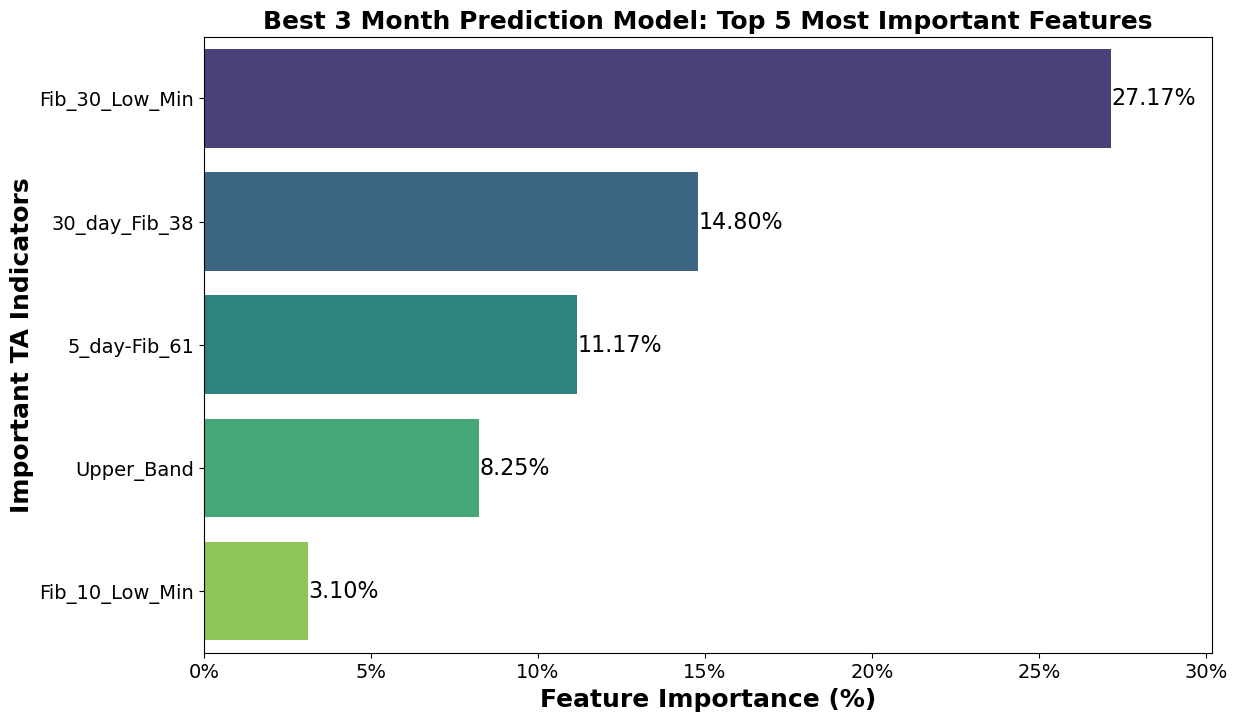

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_3_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_3_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 3)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Best 3 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [122]:
# first we will modify our feature set to add bigger lagging indicators.
# Create a new dataframe called 'df_stock_data_6_month' as a copy of 'df_stocks_price_ta'
df_stock_data_6_month = df_stocks_price_ta.copy()


In [123]:
# List of columns to create lags for (focusing on mid-term indicators)
columns_to_lag = ['Close', 'SMA_5', 'EMA_5', 'Volume', 'SMA_20',
       'SMA_50', 'EMA_5', 'EMA_20', 'EMA_50',  'EMA_12_MACD',
       'EMA_26_MACD']

# Creating lag features for each column
# [1, 3, 5, 7, 10, 12, 15, 20, 30, 60, 90, 180, 360] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
lags = [1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90, 180]
for col in columns_to_lag:
    for lag in lags:
        df_stock_data_6_month[f'{col}_lag_{lag}'] = df_stock_data_6_month[col].shift(lag)

# Do not drop NaN values to maintain continuity (XGBoost can handle NaNs)
# You can handle missing values in your model later, if needed
df_stock_data_6_month.head()

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1104426286.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_6_month[f'{col}_lag_{lag}'] = df_stock_data_6_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1104426286.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stock_data_6_month[f'{col}_lag_{lag}'] = df_stock_data_6_month[col].shift(lag)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1104426286.py:13: PerformanceWarning: DataFrame

,Symbol,Date,Close,High,Low,Volume,SMA_5,SMA_20,SMA_50,EMA_5,...,EMA_26_MACD_lag_15,EMA_26_MACD_lag_20,EMA_26_MACD_lag_25,EMA_26_MACD_lag_30,EMA_26_MACD_lag_40,EMA_26_MACD_lag_50,EMA_26_MACD_lag_60,EMA_26_MACD_lag_75,EMA_26_MACD_lag_90,EMA_26_MACD_lag_180
0,AAPL,2022-02-10,10.52,10.73,10.20,1037700.0,10.520000,10.520000,10.520000,10.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2022-02-11,10.09,10.49,10.02,480300.0,10.305000,10.305000,10.305000,10.376667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-02-14,10.22,10.46,9.97,724400.0,10.276667,10.276667,10.276667,10.324445,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2022-02-15,10.56,10.57,10.22,758700.0,10.347500,10.347500,10.347500,10.402963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2022-02-16,10.44,10.55,10.39,685200.0,10.366000,10.366000,10.366000,10.415309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
# now we're going to move onto our next model: 6 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_baseline = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_baseline = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_baseline['Close_Target'] = df_stock_data_train_6_month_baseline.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_baseline['Close_Target'] = df_stock_data_test_6_month_baseline.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_baseline = df_stock_data_train_6_month_baseline.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_baseline = df_stock_data_test_6_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_baseline.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_baseline[numeric_cols_train] = df_stock_data_train_6_month_baseline[numeric_cols_train].fillna(df_stock_data_train_6_month_baseline[numeric_cols_train].median())
df_stock_data_test_6_month_baseline[numeric_cols_test] = df_stock_data_test_6_month_baseline[numeric_cols_test].fillna(df_stock_data_test_6_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_baseline.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_6_month_baseline = df_stock_data_train_6_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_baseline = df_stock_data_train_6_month_baseline['Close_Target']

# Create X and y for testing
X_test_6_month_baseline = df_stock_data_test_6_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_baseline = df_stock_data_test_6_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_baseline shape: {X_train_6_month_baseline.shape}, y_train_6_month_baseline shape: {y_train_6_month_baseline.shape}")
print(f"X_test_6_month_baseline shape: {X_test_6_month_baseline.shape}, y_test_6_month_baseline shape: {y_test_6_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_baseline.shape[0] == 0 or X_test_6_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month.fit(X_train_6_month_baseline, y_train_6_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_baseline = model_baseline_6_month.predict(X_test_6_month_baseline)

# Calculate performance on the test data
mse_test_6_month_baseline = mean_squared_error(y_test_6_month_baseline, y_pred_6_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_baseline}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1300590180.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_baseline['Close_Target'] = df_stock_data_train_6_month_baseline.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1300590180.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_baseline['Close_Target'] = df_stock_data_test_6_month_baseline.groupby('Symbol')['Close'].shift(

Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_baseline shape: (406528, 201), y_train_6_month_baseline shape: (406528,)
X_test_6_month_baseline shape: (270615, 201), y_test_6_month_baseline shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 39556.315823205616


In [254]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_6_month_baseline` are your predictions for the test data and `y_test_6_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_baseline = mean_squared_error(y_test_6_month_baseline, y_pred_6_month_baseline)
mae_6_month_baseline = mean_absolute_error(y_test_6_month_baseline, y_pred_6_month_baseline)
rmse_6_month_baseline = np.sqrt(mse_6_month_baseline)  # Root Mean Squared Error
r2_6_month_baseline = r2_score(y_test_6_month_baseline, y_pred_6_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_baseline}')
print(f'R-squared on unseen data: {r2_6_month_baseline}')

# Additional metrics
medae_6_month_baseline = median_absolute_error(y_test_6_month_baseline, y_pred_6_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_6_month_baseline}')

dw_stat_6_month_baseline = durbin_watson(y_test_6_month_baseline - y_pred_6_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_baseline = np.mean(np.abs((y_test_6_month_baseline - y_pred_6_month_baseline) / y_test_6_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_6_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_baseline = dict(zip(X_train_6_month_baseline.columns, model_baseline_6_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_baseline = sorted(feature_importance_6_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 39556.315823205616
Mean Absolute Error on unseen data: 39.416918393972786
Root Mean Squared Error on unseen data: 198.8876965103815
R-squared on unseen data: 0.8381612251405623
Median Absolute Error on unseen data: 9.123995780944824
Durbin-Watson Statistic on unseen data: 0.028605736941907666
MAPE on unseen data: 20.33%
Fib_30_High_Max: 32.51%
Middle_Band: 13.50%
EMA_12_MACD: 8.31%
Fib_5_Low_Min: 6.21%
5_day-Fib_38: 6.09%
Volume: 5.72%
EMA_5: 4.77%
Fib_5_High_Max: 4.28%
5_day-Fib_23: 3.67%
Fib_10_High_Max: 2.76%
Low: 2.16%
VWAP: 1.29%
10_day_Fib_50: 1.26%
EMA_50: 0.87%
SMA_5_lag_1: 0.59%
High: 0.54%
Cumulative_Price_Volume: 0.50%
Fib_30_Low_Min: 0.30%
EMA_12_MACD_lag_3: 0.30%
SMA_20: 0.29%
Fib_10_Low_Min: 0.28%
EMA_26_MACD_lag_40: 0.26%
5_day-Fib_61: 0.24%
30_day_Fib_61: 0.23%
Lower_Band: 0.22%
10_day_Fib_38: 0.21%
SMA_20_lag_30: 0.18%
ATR_Prev_Close: 0.17%
SMA_50: 0.13%
ATR_High_Low: 0.13%
EMA_50_lag_30: 0.13%
SMA_5: 0.12%
Close_lag_60: 0.10%
EMA_20_

In [255]:
# 6 month prediction model
# learning rate = 0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_lr_1 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_lr_1 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_lr_1['Close_Target'] = df_stock_data_train_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_lr_1['Close_Target'] = df_stock_data_test_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_lr_1 = df_stock_data_train_6_month_lr_1.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_lr_1 = df_stock_data_test_6_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_lr_1.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_lr_1[numeric_cols_train] = df_stock_data_train_6_month_lr_1[numeric_cols_train].fillna(df_stock_data_train_6_month_lr_1[numeric_cols_train].median())
df_stock_data_test_6_month_lr_1[numeric_cols_test] = df_stock_data_test_6_month_lr_1[numeric_cols_test].fillna(df_stock_data_test_6_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_lr_1.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_6_month_lr_1 = df_stock_data_train_6_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_lr_1 = df_stock_data_train_6_month_lr_1['Close_Target']

# Create X and y for testing
X_test_6_month_lr_1 = df_stock_data_test_6_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_lr_1 = df_stock_data_test_6_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_lr_1 shape: {X_train_6_month_lr_1.shape}, y_train_6_month_lr_1 shape: {y_train_6_month_lr_1.shape}")
print(f"X_test_6_month_lr_1 shape: {X_test_6_month_lr_1.shape}, y_test_6_month_lr_1 shape: {y_test_6_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_lr_1.shape[0] == 0 or X_test_6_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_lr_1.fit(X_train_6_month_lr_1, y_train_6_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_lr_1 = model_baseline_6_month_lr_1.predict(X_test_6_month_lr_1)

# Calculate performance on the test data
mse_test = mean_squared_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1149642476.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_lr_1['Close_Target'] = df_stock_data_train_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/1149642476.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_lr_1['Close_Target'] = df_stock_data_test_6_month_lr_1.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_lr_1 shape: (406528, 201), y_train_6_month_lr_1 shape: (406528,)
X_test_6_month_lr_1 shape: (270615, 201), y_test_6_month_lr_1 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 39709.225423030846


In [256]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_lr_1` are your predictions for the test data and `y_test_6_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_lr_1 = mean_squared_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
mae_6_month_lr_1 = mean_absolute_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
rmse_6_month_lr_1 = np.sqrt(mse_6_month_lr_1)  # Root Mean Squared Error
r2_6_month_lr_1 = r2_score(y_test_6_month_lr_1, y_pred_6_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_lr_1}')
print(f'R-squared on unseen data: {r2_6_month_lr_1}')

# Additional metrics
medae_6_month_lr_1 = median_absolute_error(y_test_6_month_lr_1, y_pred_6_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_6_month_lr_1}')

dw_stat_6_month_lr_1 = durbin_watson(y_test_6_month_lr_1 - y_pred_6_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_lr_1 = np.mean(np.abs((y_test_6_month_lr_1 - y_pred_6_month_lr_1) / y_test_6_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_6_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_lr_1 = dict(zip(X_train_6_month_lr_1.columns, model_baseline_6_month_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_lr_1 = sorted(feature_importance_6_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 39709.225423030846
Mean Absolute Error on unseen data: 39.93220039169745
Root Mean Squared Error on unseen data: 199.27173764242346
R-squared on unseen data: 0.8375356182865124
Median Absolute Error on unseen data: 9.373844146728516
Durbin-Watson Statistic on unseen data: 0.02865197681840183
MAPE on unseen data: 21.11%
Fib_30_High_Max: 32.47%
EMA_12_MACD: 15.43%
Middle_Band: 8.60%
Fib_5_Low_Min: 7.65%
Volume: 5.66%
5_day-Fib_38: 5.29%
Fib_5_High_Max: 4.40%
EMA_5: 3.09%
5_day-Fib_23: 2.91%
Fib_10_High_Max: 2.21%
Low: 2.11%
EMA_50: 2.04%
10_day_Fib_50: 1.37%
VWAP: 1.29%
Cumulative_Price_Volume: 0.55%
SMA_20: 0.45%
30_day_Fib_61: 0.41%
5_day-Fib_50: 0.28%
Fib_10_Low_Min: 0.26%
5_day-Fib_61: 0.24%
10_day_Fib_38: 0.22%
ATR_Prev_Close: 0.19%
Fib_30_Low_Min: 0.18%
SMA_20_lag_30: 0.18%
EMA_26_MACD_lag_40: 0.16%
SMA_5: 0.15%
Lower_Band: 0.13%
10_day_Fib_61: 0.13%
EMA_50_lag_30: 0.11%
High: 0.11%
ATR_High_Low: 0.10%
SMA_50_lag_25: 0.10%
SMA_50: 0.09%
EMA_20: 0.

In [257]:
# 6 month prediction model
# learning rate = 0.01
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_lr_01 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_lr_01 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_lr_01['Close_Target'] = df_stock_data_train_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_lr_01['Close_Target'] = df_stock_data_test_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_lr_01 = df_stock_data_train_6_month_lr_01.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_lr_01 = df_stock_data_test_6_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_lr_01.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_lr_01[numeric_cols_train] = df_stock_data_train_6_month_lr_01[numeric_cols_train].fillna(df_stock_data_train_6_month_lr_01[numeric_cols_train].median())
df_stock_data_test_6_month_lr_01[numeric_cols_test] = df_stock_data_test_6_month_lr_01[numeric_cols_test].fillna(df_stock_data_test_6_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_lr_01.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_6_month_lr_01 = df_stock_data_train_6_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_lr_01 = df_stock_data_train_6_month_lr_01['Close_Target']

# Create X and y for testing
X_test_6_month_lr_01 = df_stock_data_test_6_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_lr_01 = df_stock_data_test_6_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_lr_01 shape: {X_train_6_month_lr_01.shape}, y_train_6_month_lr_01 shape: {y_train_6_month_lr_01.shape}")
print(f"X_test_6_month_lr_01 shape: {X_test_6_month_lr_01.shape}, y_test_6_month_lr_01 shape: {y_test_6_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_lr_01.shape[0] == 0 or X_test_6_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_lr_01.fit(X_train_6_month_lr_01, y_train_6_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_lr_01 = model_baseline_6_month_lr_01.predict(X_test_6_month_lr_01)

# Calculate performance on the test data
mse_test_6_month_lr_01 = mean_squared_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_lr_01}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2295828896.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_lr_01['Close_Target'] = df_stock_data_train_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2295828896.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_lr_01['Close_Target'] = df_stock_data_test_6_month_lr_01.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_lr_01 shape: (406528, 201), y_train_6_month_lr_01 shape: (406528,)
X_test_6_month_lr_01 shape: (270615, 201), y_test_6_month_lr_01 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 39179.243873570806


In [258]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_lr_01` are your predictions for the test data and `y_test_6_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_lr_01 = mean_squared_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
mae_6_month_lr_01 = mean_absolute_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
rmse_6_month_lr_01 = np.sqrt(mse_6_month_lr_01)  # Root Mean Squared Error
r2_6_month_lr_01 = r2_score(y_test_6_month_lr_01, y_pred_6_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_lr_01}')
print(f'R-squared on unseen data: {r2_6_month_lr_01}')

# Additional metrics
medae_6_month_lr_01 = median_absolute_error(y_test_6_month_lr_01, y_pred_6_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_6_month_lr_01}')

dw_stat_6_month_lr_01 = durbin_watson(y_test_6_month_lr_01 - y_pred_6_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_lr_01 = np.mean(np.abs((y_test_6_month_lr_01 - y_pred_6_month_lr_01) / y_test_6_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_6_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_lr_01 = dict(zip(X_train_6_month_lr_01.columns, model_baseline_6_month_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_lr_01 = sorted(feature_importance_6_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 39179.243873570806
Mean Absolute Error on unseen data: 39.05236319493131
Root Mean Squared Error on unseen data: 197.9374746569502
R-squared on unseen data: 0.8397039588631745
Median Absolute Error on unseen data: 8.80865478515625
Durbin-Watson Statistic on unseen data: 0.02858915370029223
MAPE on unseen data: 20.07%
Fib_30_High_Max: 48.93%
Middle_Band: 5.77%
EMA_12_MACD: 5.00%
Volume: 4.90%
Fib_5_Low_Min: 4.31%
Fib_5_High_Max: 4.11%
Fib_10_High_Max: 3.50%
5_day-Fib_38: 3.11%
EMA_5: 3.09%
5_day-Fib_23: 1.99%
VWAP: 1.85%
Low: 1.19%
High: 1.17%
10_day_Fib_50: 1.08%
EMA_50: 1.04%
5_day-Fib_61: 0.64%
SMA_5_lag_1: 0.54%
Fib_10_Low_Min: 0.49%
Lower_Band: 0.46%
Fib_30_Low_Min: 0.45%
10_day_Fib_38: 0.45%
SMA_20: 0.41%
Cumulative_Price_Volume: 0.41%
EMA_12_MACD_lag_3: 0.40%
30_day_Fib_61: 0.37%
EMA_50_lag_90: 0.31%
SMA_20_lag_30: 0.28%
EMA_50_lag_30: 0.24%
EMA_26_MACD_lag_40: 0.20%
ATR_High_Low: 0.19%
10_day_Fib_23: 0.19%
SMA_50: 0.17%
EMA_20: 0.16%
SMA_5: 0.1

model with learning_rate 0.01 performs the best

In [259]:
# 6 month prediction model
# learning rate = 0.01
# max_depth = 3
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_md_3 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_md_3 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_md_3['Close_Target'] = df_stock_data_train_6_month_md_3.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_md_3['Close_Target'] = df_stock_data_test_6_month_md_3.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_md_3 = df_stock_data_train_6_month_md_3.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_md_3 = df_stock_data_test_6_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_md_3.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_md_3[numeric_cols_train] = df_stock_data_train_6_month_md_3[numeric_cols_train].fillna(df_stock_data_train_6_month_md_3[numeric_cols_train].median())
df_stock_data_test_6_month_md_3[numeric_cols_test] = df_stock_data_test_6_month_md_3[numeric_cols_test].fillna(df_stock_data_test_6_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_md_3.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_6_month_md_3 = df_stock_data_train_6_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_md_3 = df_stock_data_train_6_month_md_3['Close_Target']

# Create X and y for testing
X_test_6_month_md_3 = df_stock_data_test_6_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_md_3 = df_stock_data_test_6_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_md_3 shape: {X_train_6_month_md_3.shape}, y_train_6_month_md_3 shape: {y_train_6_month_md_3.shape}")
print(f"X_test_6_month_md_3 shape: {X_test_6_month_md_3.shape}, y_test_6_month_md_3 shape: {y_test_6_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_md_3.shape[0] == 0 or X_test_6_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_md_3.fit(X_train_6_month_md_3, y_train_6_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_md_3 = model_baseline_6_month_md_3.predict(X_test_6_month_md_3)

# Calculate performance on the test data
mse_test_6_month_md_3 = mean_squared_error(y_test_6_month_md_3, y_pred_6_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_md_3}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3230166457.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_md_3['Close_Target'] = df_stock_data_train_6_month_md_3.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/3230166457.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_md_3['Close_Target'] = df_stock_data_test_6_month_md_3.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_md_3 shape: (406528, 201), y_train_6_month_md_3 shape: (406528,)
X_test_6_month_md_3 shape: (270615, 201), y_test_6_month_md_3 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 31411.174267588787


In [260]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_md_3` are your predictions for the test data and `y_test_6_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_md_3 = mean_squared_error(y_test_6_month_md_3, y_pred_6_month_md_3)
mae_6_month_md_3 = mean_absolute_error(y_test_6_month_md_3, y_pred_6_month_md_3)
rmse_6_month_md_3 = np.sqrt(mse_6_month_md_3)  # Root Mean Squared Error
r2_6_month_md_3 = r2_score(y_test_6_month_md_3, y_pred_6_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_md_3}')
print(f'R-squared on unseen data: {r2_6_month_md_3}')

# Additional metrics
medae_6_month_md_3 = median_absolute_error(y_test_6_month_md_3, y_pred_6_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_6_month_md_3}')

dw_stat_6_month_md_3 = durbin_watson(y_test_6_month_md_3 - y_pred_6_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_md_3 = np.mean(np.abs((y_test_6_month_md_3 - y_pred_6_month_md_3) / y_test_6_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_6_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_md_3 = dict(zip(X_train_6_month_md_3.columns, model_baseline_6_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_md_3 = sorted(feature_importance_6_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 31411.174267588787
Mean Absolute Error on unseen data: 34.84146322021573
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.871485858716382
Median Absolute Error on unseen data: 8.994926452636719
Durbin-Watson Statistic on unseen data: 0.020845241129731375
MAPE on unseen data: 21.51%
Fib_10_High_Max: 17.93%
Fib_30_High_Max: 13.03%
Fib_5_Low_Min: 12.74%
ATR_High_Low: 5.86%
10_day_Fib_50: 4.75%
EMA_50_lag_25: 4.42%
EMA_5: 2.79%
Middle_Band: 2.77%
Volume: 2.74%
EMA_12_MACD: 2.23%
EMA_50: 2.11%
Fib_5_High_Max: 2.10%
5_day-Fib_61: 1.93%
Low: 1.78%
High: 1.60%
30_day_Fib_61: 1.47%
VWAP: 1.45%
Fib_30_Low_Min: 1.18%
EMA_26_MACD_lag_40: 1.09%
SMA_50: 1.05%
Fib_10_Low_Min: 1.02%
SMA_50_lag_90: 1.01%
SMA_5: 0.98%
EMA_50_lag_30: 0.97%
ATR: 0.92%
SMA_50_lag_20: 0.76%
EMA_20: 0.69%
Close_lag_90: 0.65%
5_day-Fib_23: 0.58%
SMA_50_lag_25: 0.55%
ATR_Prev_Close: 0.54%
Lower_Band: 0.53%
Std_Dev: 0.43%
ATR_True_Range: 0.38%
Volume_lag_7

In [208]:
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print({
        'Symbol': symbol,
        'First Available Date': first_date,
        'Last Available Date': last_date
    })

# Example usage:
print_stock_date_range(df_stock_data_test, 'AAPL')


{'Symbol': 'AAPL', 'First Available Date': '2024-01-11', 'Last Available Date': '2024-08-15'}


In [222]:
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test, 'AAPL', '2024-02-09')


Symbol: AAPL
Date: 2024-02-09
Close Price: 11.25
Predicted Price Date: 2024-06-07
Predicted Price: 10.22
Percent Error: 9.16%


In [261]:
# 6 month prediction model
# learning rate = 0.01
# max_depth = 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
df_stock_data_6_month = df_stock_data_6_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
df_stock_data_train_6_month_md_7 = df_stock_data_6_month[df_stock_data_6_month['Date'] <= '2023-07-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
df_stock_data_test_6_month_md_7 = df_stock_data_6_month[df_stock_data_6_month['Date'] > '2024-01-10']

# Check if the test set is empty
if df_stock_data_test_6_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
df_stock_data_train_6_month_md_7['Close_Target'] = df_stock_data_train_6_month_md_7.groupby('Symbol')['Close'].shift(-120)
df_stock_data_test_6_month_md_7['Close_Target'] = df_stock_data_test_6_month_md_7.groupby('Symbol')['Close'].shift(-120)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
df_stock_data_train_6_month_md_7 = df_stock_data_train_6_month_md_7.dropna(subset=['Close_Target'])
df_stock_data_test_6_month_md_7 = df_stock_data_test_6_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
df_stock_data_train_6_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
df_stock_data_test_6_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = df_stock_data_train_6_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = df_stock_data_test_6_month_md_7.select_dtypes(include=[np.number]).columns

df_stock_data_train_6_month_md_7[numeric_cols_train] = df_stock_data_train_6_month_md_7[numeric_cols_train].fillna(df_stock_data_train_6_month_md_7[numeric_cols_train].median())
df_stock_data_test_6_month_md_7[numeric_cols_test] = df_stock_data_test_6_month_md_7[numeric_cols_test].fillna(df_stock_data_test_6_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {df_stock_data_train_6_month_md_7.shape}")
print(f"Testing data shape: {df_stock_data_test_6_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_6_month_md_7 = df_stock_data_train_6_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_6_month_md_7 = df_stock_data_train_6_month_md_7['Close_Target']

# Create X and y for testing
X_test_6_month_md_7 = df_stock_data_test_6_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_6_month_md_7 = df_stock_data_test_6_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_6_month_md_7 shape: {X_train_6_month_md_7.shape}, y_train_6_month_md_7 shape: {y_train_6_month_md_7.shape}")
print(f"X_test_6_month_md_7 shape: {X_test_6_month_md_7.shape}, y_test_6_month_md_7 shape: {y_test_6_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_6_month_md_7.shape[0] == 0 or X_test_6_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_6_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_6_month_md_7.fit(X_train_6_month_md_7, y_train_6_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_6_month_md_7 = model_baseline_6_month_md_7.predict(X_test_6_month_md_7)

# Calculate performance on the test data
mse_test_6_month_md_7 = mean_squared_error(y_test_6_month_md_7, y_pred_6_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_6_month_md_7}')



/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2152527354.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_train_6_month_md_7['Close_Target'] = df_stock_data_train_6_month_md_7.groupby('Symbol')['Close'].shift(-120)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_90942/2152527354.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock_data_test_6_month_md_7['Close_Target'] = df_stock_data_test_6_month_md_7.groupby('Symbol')['Close'].shift(-120)


Training data shape: (406528, 205)
Testing data shape: (270615, 205)
X_train_6_month_md_7 shape: (406528, 201), y_train_6_month_md_7 shape: (406528,)
X_test_6_month_md_7 shape: (270615, 201), y_test_6_month_md_7 shape: (270615,)
Mean Squared Error on unseen data (post-February 10, 2024): 43856.30757644138


In [262]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_6_month_md_7` are your predictions for the test data and `y_test_6_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_6_month_md_7 = mean_squared_error(y_test_6_month_md_7, y_pred_6_month_md_7)
mae_6_month_md_7 = mean_absolute_error(y_test_6_month_md_7, y_pred_6_month_md_7)
rmse_6_month_md_7 = np.sqrt(mse_6_month_md_7)  # Root Mean Squared Error
r2_6_month_md_7 = r2_score(y_test_6_month_md_7, y_pred_6_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_6_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_6_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_6_month_md_7}')
print(f'R-squared on unseen data: {r2_6_month_md_7}')

# Additional metrics
medae_6_month_md_7 = median_absolute_error(y_test_6_month_md_7, y_pred_6_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_6_month_md_7}')

dw_stat_6_month_md_7 = durbin_watson(y_test_6_month_md_7 - y_pred_6_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_6_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_6_month_md_7 = np.mean(np.abs((y_test_6_month_md_7 - y_pred_6_month_md_7) / y_test_6_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_6_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_6_month_md_7 = dict(zip(X_train_6_month_md_7.columns, model_baseline_6_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_6_month_md_7 = sorted(feature_importance_6_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_6_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 43856.30757644138
Mean Absolute Error on unseen data: 40.75621874158073
Root Mean Squared Error on unseen data: 209.41897616128625
R-squared on unseen data: 0.8205684493026995
Median Absolute Error on unseen data: 9.070610046386719
Durbin-Watson Statistic on unseen data: 0.02741931648833066
MAPE on unseen data: 20.17%
Fib_30_High_Max: 45.49%
EMA_12_MACD: 10.16%
Fib_5_High_Max: 6.96%
Middle_Band: 6.71%
EMA_5: 6.36%
Fib_5_Low_Min: 4.69%
Fib_10_High_Max: 3.66%
Volume: 3.49%
VWAP: 1.42%
EMA_50: 1.20%
30_day_Fib_61: 1.15%
High: 1.00%
Low: 0.95%
5_day-Fib_23: 0.78%
10_day_Fib_50: 0.59%
10_day_Fib_23: 0.56%
Cumulative_Price_Volume: 0.45%
SMA_20_lag_30: 0.40%
Fib_10_Low_Min: 0.31%
EMA_26_MACD: 0.30%
5_day-Fib_61: 0.26%
EMA_12_MACD_lag_3: 0.25%
SMA_50: 0.24%
Fib_30_Low_Min: 0.23%
EMA_50_lag_25: 0.22%
EMA_50_lag_90: 0.20%
5_day-Fib_38: 0.15%
EMA_50_lag_75: 0.09%
Lower_Band: 0.07%
SMA_50_lag_25: 0.07%
EMA_26_MACD_lag_60: 0.07%
SMA_5: 0.06%
EMA_26_MACD_lag_180: 0

best model: learning_rate = 0.01 and max_depth = 3

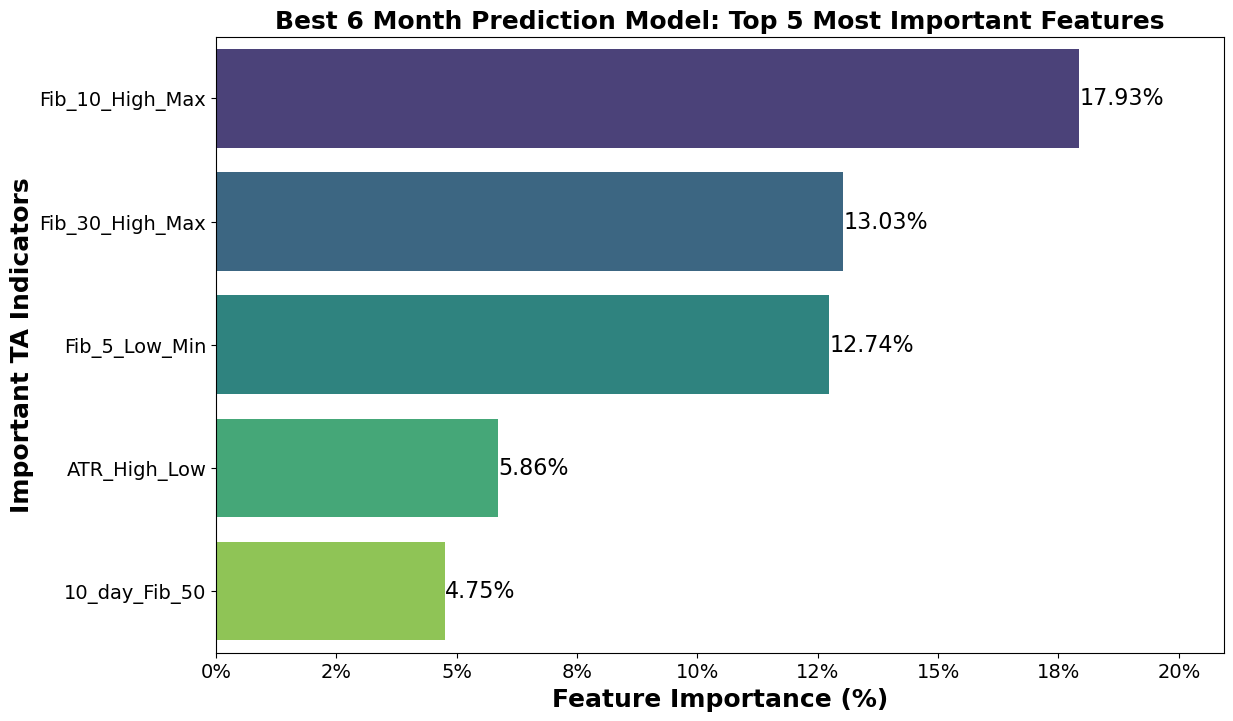

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_6_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_6_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 3)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Best 6 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


Best model metrics

most important metrics to visualize:

1. Root Mean Squared Error
2. R-squared
3. MAPE
4. Median Absolute Error

1 week:

Mean Squared Error on unseen data: 7604.147083529955
Mean Absolute Error on unseen data: 10.044193260395863
Root Mean Squared Error on unseen data: 87.20176078227982
R-squared on unseen data: 0.9656152295864199
Median Absolute Error on unseen data: 1.588897705078125
Durbin-Watson Statistic on unseen data: 0.1674710246723756
MAPE on unseen data: 3.96%




Fib_10_Low_Min: 63.23%
Fib_30_High_Max: 14.79%
Low: 4.90%
5_day-Fib_38: 4.25%
High: 3.05%
5_day-Fib_61: 1.76%
10_day_Fib_23: 1.33%
Fib_30_Low_Min: 1.28%
Volume: 1.07%
Fib_5_Low_Min: 0.89%
5_day-Fib_50: 0.66%
EMA_5: 0.49%
SMA_5: 0.44%
30_day_Fib_38: 0.42%
5_day-Fib_23: 0.24%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.20%
EMA_12_MACD: 0.08%
SMA_20: 0.08%
30_day_Fib_50: 0.06%
VWAP: 0.05%
30_day_Fib_61: 0.05%
SMA_5_lag_7: 0.05%
ATR_True_Range: 0.05%
SMA_50: 0.05%
ATR_Prev_Close: 0.05%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.04%
EMA_20: 0.04%
ATR: 0.03%
Upper_Band: 0.03%
Fib_10_High_Max: 0.01%
Lower_Band: 0.01%
Volume_lag_1: 0.01%
EMA_26_MACD: 0.01%
EMA_50: 0.01%
10_day_Fib_61: 0.01%


1 month:

Mean Squared Error on unseen data: 10844.724459170979
Mean Absolute Error on unseen data: 15.639166248218757
Root Mean Squared Error on unseen data: 104.13800679469037
R-squared on unseen data: 0.9513849924746814
Median Absolute Error on unseen data: 3.326946258544922
Durbin-Watson Statistic on unseen data: 0.0750817215794377
MAPE on unseen data: 7.82%

30_day_Fib_23: 52.41%
Fib_30_High_Max: 32.44%
Fib_5_Low_Min: 2.25%
Low: 2.08%
10_day_Fib_23: 1.96%
High: 1.77%
Volume: 1.43%
5_day-Fib_50: 1.11%
30_day_Fib_50: 0.68%
10_day_Fib_38: 0.62%
5_day-Fib_23: 0.48%
Fib_10_High_Max: 0.28%
Fib_10_Low_Min: 0.25%
Std_Dev: 0.21%
VWAP: 0.21%
ATR_Prev_Close: 0.20%
EMA_5: 0.19%
Fib_5_High_Max: 0.19%
Cumulative_Price_Volume: 0.17%
Lower_Band: 0.16%
EMA_26_MACD: 0.14%
30_day_Fib_61: 0.11%
SMA_5: 0.11%
SMA_20_lag_1: 0.06%
Upper_Band: 0.05%
5_day-Fib_61: 0.04%
ATR_True_Range: 0.04%
Cumulative_Volume: 0.04%
30_day_Fib_38: 0.03%
10_day_Fib_61: 0.03%
EMA_50: 0.02%
Fib_30_Low_Min: 0.02%
ATR: 0.02%
Volume_lag_1: 0.02%
Close_lag_1: 0.02%
EMA_20_lag_20: 0.02%
SMA_50: 0.01%
EMA_12_MACD_lag_15: 0.01%
EMA_12_MACD_lag_12: 0.01%


3 months:

Mean Squared Error on unseen data: 25855.13009374476
Mean Absolute Error on unseen data: 25.29591435606357
Root Mean Squared Error on unseen data: 160.79530494931984
R-squared on unseen data: 0.8883720519645201
Median Absolute Error on unseen data: 6.283714294433594
Durbin-Watson Statistic on unseen data: 0.017109218495924613
MAPE on unseen data: 15.52%

Fib_30_Low_Min: 27.17%
30_day_Fib_38: 14.80%
5_day-Fib_61: 11.17%
Upper_Band: 8.25%
Fib_10_Low_Min: 3.10%
10_day_Fib_50: 2.76%
Close_lag_1: 2.34%
Volume: 1.87%
EMA_5: 1.82%
Fib_5_Low_Min: 1.69%
Fib_5_High_Max: 1.51%
30_day_Fib_23: 1.50%
High: 1.48%
EMA_50_lag_25: 1.37%
30_day_Fib_50: 1.29%
ATR_High_Low: 1.20%
EMA_26_MACD: 1.11%
EMA_50: 1.08%
SMA_50: 1.02%
ATR: 1.00%
10_day_Fib_61: 0.87%
Low: 0.86%
EMA_12_MACD: 0.82%
Close_lag_90: 0.76%
5_day-Fib_23: 0.76%
EMA_20: 0.73%
SMA_20_lag_90: 0.60%
EMA_12_MACD_lag_90: 0.58%
10_day_Fib_38: 0.57%
VWAP: 0.55%
30_day_Fib_61: 0.54%
Volume_lag_50: 0.53%
ATR_True_Range: 0.39%
ATR_Prev_Close: 0.32%
SMA_5_lag_90: 0.31%
EMA_50_lag_30: 0.30%
Lower_Band: 0.28%
Fib_30_High_Max: 0.24%
Std_Dev: 0.23%
Volume_lag_3: 0.16%
Volume_lag_25: 0.15%
SMA_50_lag_60: 0.13%
EMA_26_MACD_lag_40: 0.13%
Cumulative_Price_Volume: 0.13%
EMA_50_lag_20: 0.12%
Volume_lag_75: 0.11%
EMA_12_MACD_lag_20: 0.10%
SMA_50_lag_10: 0.07%
Volume_lag_60: 0.07%
EMA_20_lag_15: 0.06%
EMA_50_lag_50: 0.05%
SMA_50_lag_3: 0.05%
EMA_5_lag_40: 0.04%
SMA_50_lag_5: 0.04%
EMA_50_lag_75: 0.04%
Cumulative_Volume: 0.04%
SMA_5_lag_60: 0.04%
Fib_10_High_Max: 0.04%
EMA_50_lag_60: 0.03%
SMA_50_lag_30: 0.03%
SMA_5_lag_25: 0.03%
Volume_lag_90: 0.03%
SMA_20_lag_25: 0.03%
SMA_50_lag_7: 0.03%
ATR_High_Close: 0.02%
EMA_50_lag_90: 0.02%
SMA_20_lag_40: 0.02%
Signal_Line: 0.02%
Volume_lag_1: 0.02%
SMA_50_lag_20: 0.02%
SMA_20_lag_30: 0.02%
EMA_26_MACD_lag_50: 0.02%
SMA_5_lag_50: 0.02%
SMA_50_lag_15: 0.02%
Volume_lag_40: 0.02%
SMA_50_lag_25: 0.01%
EMA_50_lag_15: 0.01%
EMA_12_MACD_lag_40: 0.01%
MACD: 0.01%
SMA_20_lag_20: 0.01%
EMA_12_MACD_lag_15: 0.01%
Volume_lag_5: 0.01%
SMA_5: 0.01%
SMA_5_lag_15: 0.01%
EMA_26_MACD_lag_30: 0.01%
Close_lag_20: 0.01%
EMA_20_lag_50: 0.01%
Close_lag_25: 0.01%
Volume_lag_20: 0.01%
Close_lag_40: 0.01%
EMA_5_lag_50: 0.01%
SMA_5_lag_40: 0.01%
SMA_50_lag_90: 0.01%
5_day-Fib_50: 0.01%
SMA_50_lag_40: 0.01%
EMA_5_lag_75: 0.01%
SMA_20_lag_50: 0.01%
Close_lag_10: 0.01%
EMA_12_MACD_lag_5: 0.01%


6 months:

Mean Squared Error on unseen data: 31411.174267588787
Mean Absolute Error on unseen data: 34.84146322021573
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.871485858716382
Median Absolute Error on unseen data: 8.994926452636719
Durbin-Watson Statistic on unseen data: 0.020845241129731375
MAPE on unseen data: 21.51%

Fib_10_High_Max: 17.93%
Fib_30_High_Max: 13.03%
Fib_5_Low_Min: 12.74%
ATR_High_Low: 5.86%
10_day_Fib_50: 4.75%
EMA_50_lag_25: 4.42%
EMA_5: 2.79%
Middle_Band: 2.77%
Volume: 2.74%
EMA_12_MACD: 2.23%
EMA_50: 2.11%
Fib_5_High_Max: 2.10%
5_day-Fib_61: 1.93%
Low: 1.78%
High: 1.60%
30_day_Fib_61: 1.47%
VWAP: 1.45%
Fib_30_Low_Min: 1.18%
EMA_26_MACD_lag_40: 1.09%
SMA_50: 1.05%
Fib_10_Low_Min: 1.02%
SMA_50_lag_90: 1.01%
SMA_5: 0.98%
EMA_50_lag_30: 0.97%
ATR: 0.92%
SMA_50_lag_20: 0.76%
EMA_20: 0.69%
Close_lag_90: 0.65%
5_day-Fib_23: 0.58%
SMA_50_lag_25: 0.55%
ATR_Prev_Close: 0.54%
Lower_Band: 0.53%
Std_Dev: 0.43%
ATR_True_Range: 0.38%
Volume_lag_75: 0.35%
SMA_5_lag_60: 0.31%
30_day_Fib_23: 0.29%
EMA_12_MACD_lag_3: 0.21%
10_day_Fib_38: 0.21%
Volume_lag_60: 0.20%
SMA_50_lag_75: 0.20%
Volume_lag_1: 0.18%
EMA_5_lag_75: 0.17%
SMA_50_lag_3: 0.17%
Close_lag_180: 0.17%
Cumulative_Price_Volume: 0.16%
Volume_lag_50: 0.15%
5_day-Fib_50: 0.15%
EMA_50_lag_1: 0.14%
EMA_50_lag_90: 0.13%
Volume_lag_30: 0.13%
10_day_Fib_61: 0.12%
EMA_50_lag_40: 0.09%
EMA_20_lag_180: 0.08%
SMA_50_lag_40: 0.08%
Volume_lag_25: 0.08%
EMA_50_lag_75: 0.06%
Volume_lag_3: 0.05%
Cumulative_Volume: 0.04%
Volume_lag_5: 0.04%
EMA_20_lag_90: 0.04%
Signal_Line: 0.04%
EMA_50_lag_180: 0.04%
Volume_lag_40: 0.04%
EMA_26_MACD: 0.03%
EMA_26_MACD_lag_180: 0.03%
Upper_Band: 0.03%
EMA_12_MACD_lag_180: 0.03%
EMA_20_lag_3: 0.03%
EMA_5_lag_40: 0.03%
EMA_12_MACD_lag_40: 0.03%
SMA_50_lag_180: 0.02%
SMA_20_lag_15: 0.02%
Volume_lag_20: 0.02%
SMA_20_lag_30: 0.02%
EMA_12_MACD_lag_25: 0.02%
EMA_5_lag_60: 0.02%
SMA_5_lag_7: 0.02%
Volume_lag_180: 0.02%
EMA_5_lag_50: 0.02%
EMA_50_lag_15: 0.02%
SMA_50_lag_50: 0.02%
SMA_20_lag_60: 0.02%
SMA_20_lag_40: 0.02%
EMA_26_MACD_lag_10: 0.01%
Close_lag_20: 0.01%
5_day-Fib_38: 0.01%
Close_lag_50: 0.01%
MACD: 0.01%
EMA_20_lag_40: 0.01%
Close_lag_10: 0.01%
EMA_20_lag_50: 0.01%
SMA_5_lag_30: 0.01%
SMA_50_lag_10: 0.01%
Volume_lag_10: 0.01%
MACD_Histogram: 0.01%
EMA_50_lag_20: 0.01%
RSI: 0.01%
10_day_Fib_23: 0.01%
%D: 0.01%
Close_lag_5: 0.01%
Volume_lag_90: 0.01%
Volume_lag_15: 0.01%
SMA_20_lag_3: 0.01%
EMA_20_lag_15: 0.01%
SMA_5_lag_90: 0.01%
EMA_12_MACD_lag_50: 0.01%
SMA_20_lag_75: 0.01%
EMA_20_lag_75: 0.01%
EMA_50_lag_60: 0.01%
SMA_50_lag_1: 0.01%
SMA_50_lag_60: 0.01%
EMA_26_MACD_lag_60: 0.01%
Close_lag_1: 0.01%
Volume_lag_7: 0.01%
SMA_20_lag_90: 0.01%
Close_lag_75: 0.01%




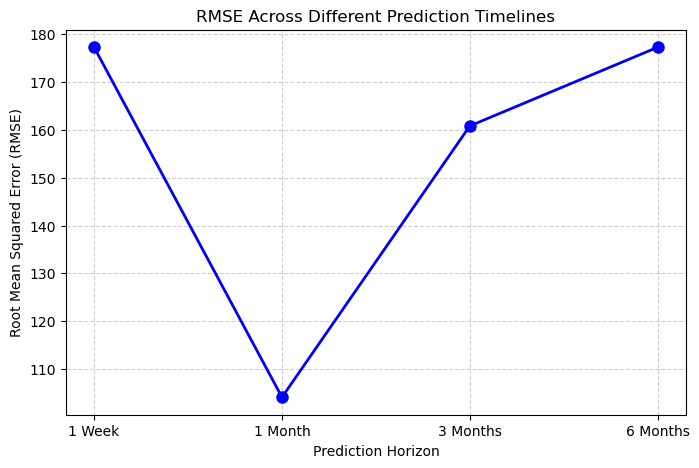

In [293]:
# Root mean squared error graph
import matplotlib.pyplot as plt

# Define time horizons and RMSE values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
rmse_values = [rmse_1_week_md_7, rmse_1_month_md_7, rmse_3_month_md_3, rmse_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, rmse_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE Across Different Prediction Timelines")
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


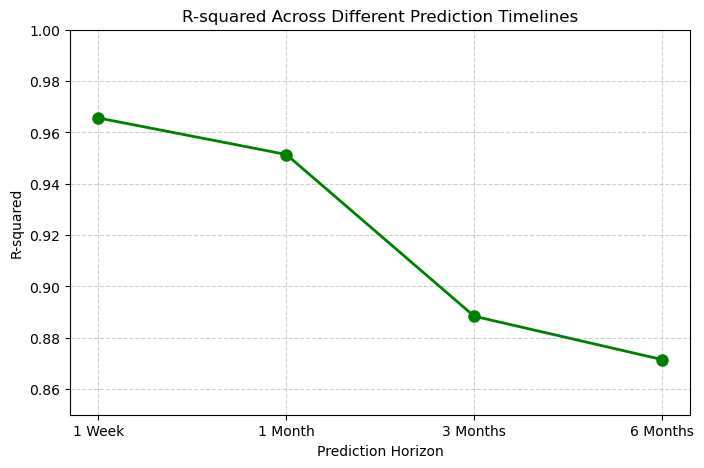

In [297]:
# r squared graph
import matplotlib.pyplot as plt

# Define time horizons and R-squared values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
r_squared_values = [r2_1_week_md_7, r2_1_month_md_7, r2_3_month_md_3, r2_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, r_squared_values, marker='o', linestyle='-', color='g', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("R-squared")
plt.title("R-squared Across Different Prediction Timelines")
plt.ylim(0.85, 1.0)  # Setting limits for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


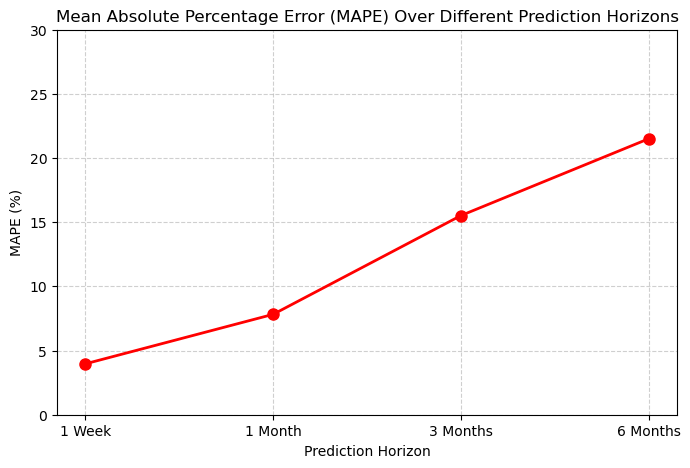

In [298]:
# MAPE graph
import matplotlib.pyplot as plt

# Define time horizons and MAPE values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
mape_values = [mape_1_week_md_7, mape_1_month_md_7, mape_3_month_md_3, mape_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, mape_values, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("MAPE (%)")
plt.title("Mean Absolute Percentage Error (MAPE) Over Different Prediction Horizons")
plt.ylim(0, 30)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


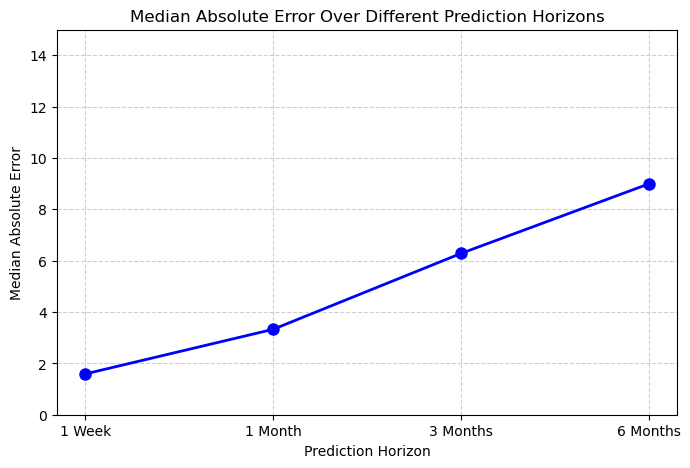

In [299]:
# Median Absolute Error
import matplotlib.pyplot as plt

# Define time horizons and Median Absolute Error values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
medae_values = [medae_1_week_md_7, medae_1_month_md_7, medae_3_month_md_3, medae_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, medae_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Median Absolute Error")
plt.title("Median Absolute Error Over Different Prediction Horizons")
plt.ylim(0, 15)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()
